# Universidad de Buenos Aires
# Aprendizaje Profundo - TP1
# Cohorte 20 - 3er bimestre 2025


Este primer TP comienza la semana de la clase 2 y la ventana de entrega estará abierta hasta las **23hs del jueves 31 de julio (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP1 EQUIVALE AL 60% DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/2UKBgNLjBZZ5XCeH9)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP1.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP1-Co20.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

# **PREGUNTA 1**

## **Comparación de Gradiente Descendente y Adam en una Función de Costo No Convexa**

En este ejercicio se compararán los optimizadores Gradiente Descendente (GD) y Adam en la minimización de una función de costo basada en una red neuronal de una sola neurona:
$$
z = w x + b
$$
Con función de activación tangente hiperbólica:

$$
\hat{y} = \tanh(z) = \tanh(w x + b)
$$

\\

Se analizará la trayectoria de aprendizaje de ambos algoritmos y se evaluará su eficiencia con diferentes tasas de aprendizaje (learning rate).

\\

La función de costo utilizada es el Error Cuadrático Medio (MSE):

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2
$$

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} ( \tanh(w x_i + b) - y_i )^2
$$

donde \\( w \\) y \\( b \\) son los parámetros a optimizar.

\\

Si bien es cierto, en estos experimentos estamos comparando optimizadores (GD vs Adam), y no entrenando un modelo como tal, de igual forma se necesitará una especie de dataset. Este será sintético y solo de prueba, por ende tendrán cierta libertad para elegir sus valores. Sin embargo deberán tomar en cuenta que cumpla la siguiente estructura:

`x = np.linspace(ini, fin, n)`

donde `x` es un array de una sola dimensión y con `n` cantidad de valores. Y tiene un rango de valores desde `ini` hasta `fin`. Recomiendo que sea simétrico, es decir, los mismos valores solo que con el signo cambiado, por ejemplo `ini=-3, fin=3`.

\\

Y con un target `y`:

`y = funcion_no_lineal(x) + ruido`

donde `y` es también un vector de una sola dimensión de tamaño `n` que sigue un patrón no lineal con respecto a `x` adicionando un ruido que puede ser creado con algunas de las funciones del paquete `np.random`.


### 1a) Implementación del Gradiente Descendente (1 punto)
- Implementar el algoritmo del Gradiente Descendente (GD) para minimizar \\( J(w, b) \\).
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Inicializar valores de \\( w \\) y \\( b \\) de manera aleatoria con `np.random.randn()` para cada learning rate.
- Graficar la función de Costo \\( J(w, b) \\) VS número de época

\\

El optimizador del Gradiente Descendente se debe implementar haciendo el código desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

In [1]:
from typing import Literal, Optional, Dict, List, Tuple
import numpy as np
from matplotlib import pyplot as plt

SEED = 42

In [2]:
class SimplePerceptron:
    """
    A simple implementation of a single neuron perceptron. With parametrizable
    input and one output. The activation function is the hyperbolic tangent
    function (tanh) by default.
    """
    def __init__(
        self, 
    ):
        """
        Init method for the perceptron.
        """
        np.random.seed(SEED)  # Set seed for reproducibility
        self.weight = np.random.rand(1)
        self.bias = np.random.rand(1)
        
        # Saves the weights and bias for each epoch
        self.w_b: Tuple[List[float], List[float]] = (list(), list())
        self._activation_fun = np.tanh
        self._lr: float = None

    def _reset_weights(self):
        """
        Resets the weights and bias of the perceptron to random values.
        """
        np.random.seed(SEED)
        self.weight = np.random.rand(1)
        self.bias = np.random.rand(1)
        self.w_b = (list(), list())  # Reset the history of weights and bias

    @staticmethod
    def batch_generator(X, y, batch_size=32, shuffle=False):
        n_samples = X.shape[0]
        indices = np.arange(n_samples)

        if shuffle:
            np.random.shuffle(indices)

        for start_idx in range(0, n_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            yield X[batch_indices], y[batch_indices]

    def train(
        self, 
        inputs: np.ndarray, 
        targets: np.ndarray,
        epochs: int,
        lr: float,
        optim: Optional[Literal['adam']] = None,
        batch_size: Optional[int] = None,
        checkpoint: bool = False):
        """
        Trains the perceptron using the provided inputs and targets.

        Parameters
        ----------
        inputs: np.ndarray
            Input data to perform the forward pass.
        targets: np.ndarray
            Target output.
        epochs: int
            Number of epochs.
        lr: float
            Learning rate for the training.
        optim: Optional[Literal['adam']]
            Optimization algorithm to be used. Currently only adam is supported.
            If None, no optimization is applied and the perceptron will use a
            gradient descent update.
        checkpoint: bool
            If True, retrains on top of the wheights and bias of the perceptron.
            If False, the perceptron will be re initialized with random weights
            and bias.
        
        Mutates
        -------
        self.weights: np.ndarray
            Updates the weights of the perceptron.
        self.bias: float
            Updates the bias of the perceptron.
        """
        assert inputs.shape[0] == targets.shape[0], "mismatched input and target sizes"
        
        # mse per epoch
        self.mse = list()

        # Reset weights and bias if not checkpointing
        if not checkpoint:
            self._reset_weights()

        if optim == 'adam':
            r_w, v_w = np.zeros_like(self.weight), np.zeros_like(self.weight)
            r_b, v_b = np.zeros_like(self.bias), np.zeros_like(self.bias)
            p1, p2  = 0.9, 0.999

        _batch_size = len(inputs) if batch_size is None else batch_size
        
        weighs = list()
        bias = list()

        for epoch in range(epochs):

            error = list()
            # create batches
            for x_batch, y_batch in self.batch_generator(
                X=inputs, y=targets, batch_size=_batch_size, shuffle=False):

                # Forward pass
                output = self.predict(inputs=x_batch)

                # Calculate the loss (mean squared error)
                error.append(np.mean(np.power(y_batch - output, 2)).item())
                
                # Derivative of the loss with respect to the output
                grad = -2 * (y_batch - output) * (1 - output ** 2)
                grad_w = np.mean(grad * x_batch)
                grad_b = np.mean(grad)

                if optim is None:
                    # Gradient descent update
                    self.weight -= lr * grad_w
                    self.bias -= lr * grad_b

                elif optim == 'adam':
                    # Momentum update for weights
                    v_w = p1 * v_w + (1 - p1) * grad_w
                    r_w = p2 * r_w + (1 - p2) * (grad_w ** 2)
                    # Momentum update for bias
                    v_b = p1 * v_b + (1 - p1) * grad_b
                    r_b = p2 * r_b + (1 - p2) * (grad_b ** 2)                    
                    self.weight -= lr * v_w / (np.sqrt(r_w) + 1e-8)  # Adding epsilon to avoid division by zero
                    self.bias -= lr * v_b / (np.sqrt(r_b) + 1e-8)
                
            self.mse.append(np.mean(error).item())  # Average loss for the epoch
            weighs.append(self.weight.item())
            bias.append(self.bias.item())
            print(f'Epoch {epoch + 1}/{epochs}, Avg Loss: {self.mse[-1]:.4f}')
        self.w_b = (weighs, bias)

    def predict(self, inputs: np.ndarray) -> List[float]:
        """
        Performs a forward pass through the perceptron.
        
        Parameters
        ----------
        inputs: np.ndarray
            Input data to the perceptron.
        Returns
        -------
        float
            Output of the perceptron after applying the activation function.
        """
        z = self.weight * inputs + self.bias
        return np.tanh(z)

Genero data de entrada y salida

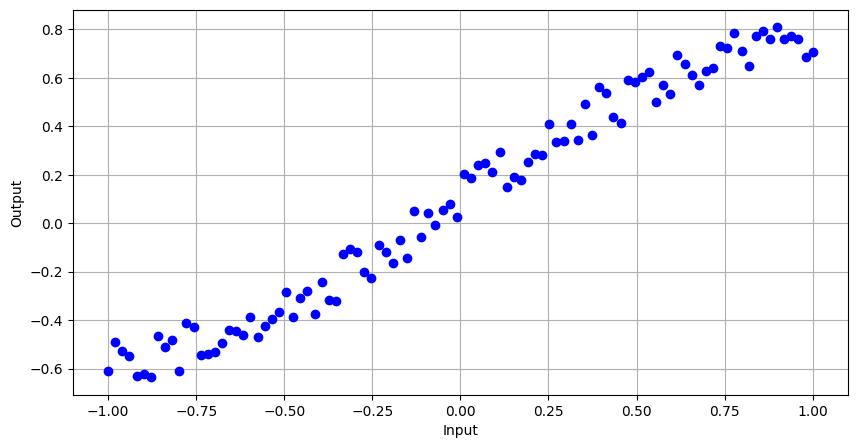

In [3]:
# for reproducibility
np.random.seed(42)

n_samples = 100
input = np.linspace(-1, 1, n_samples)
target = np.tanh(np.sin(input)) + 0.2 * np.random.rand(len(input))

plt.figure(figsize=(10, 5))
plt.plot(input, target, color='blue', marker='o', linestyle='None')
plt.title('Plot of tanh(sin(x))')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('')
plt.grid()
plt.show()


Epoch 1/100, Avg Loss: 0.5321
Epoch 2/100, Avg Loss: 0.4743
Epoch 3/100, Avg Loss: 0.4121
Epoch 4/100, Avg Loss: 0.3479
Epoch 5/100, Avg Loss: 0.2850
Epoch 6/100, Avg Loss: 0.2268
Epoch 7/100, Avg Loss: 0.1761
Epoch 8/100, Avg Loss: 0.1344
Epoch 9/100, Avg Loss: 0.1016
Epoch 10/100, Avg Loss: 0.0767
Epoch 11/100, Avg Loss: 0.0582
Epoch 12/100, Avg Loss: 0.0448
Epoch 13/100, Avg Loss: 0.0350
Epoch 14/100, Avg Loss: 0.0280
Epoch 15/100, Avg Loss: 0.0228
Epoch 16/100, Avg Loss: 0.0191
Epoch 17/100, Avg Loss: 0.0164
Epoch 18/100, Avg Loss: 0.0143
Epoch 19/100, Avg Loss: 0.0128
Epoch 20/100, Avg Loss: 0.0116
Epoch 21/100, Avg Loss: 0.0106
Epoch 22/100, Avg Loss: 0.0099
Epoch 23/100, Avg Loss: 0.0093
Epoch 24/100, Avg Loss: 0.0088
Epoch 25/100, Avg Loss: 0.0084
Epoch 26/100, Avg Loss: 0.0080
Epoch 27/100, Avg Loss: 0.0077
Epoch 28/100, Avg Loss: 0.0075
Epoch 29/100, Avg Loss: 0.0072
Epoch 30/100, Avg Loss: 0.0070
Epoch 31/100, Avg Loss: 0.0068
Epoch 32/100, Avg Loss: 0.0066
Epoch 33/100, Avg

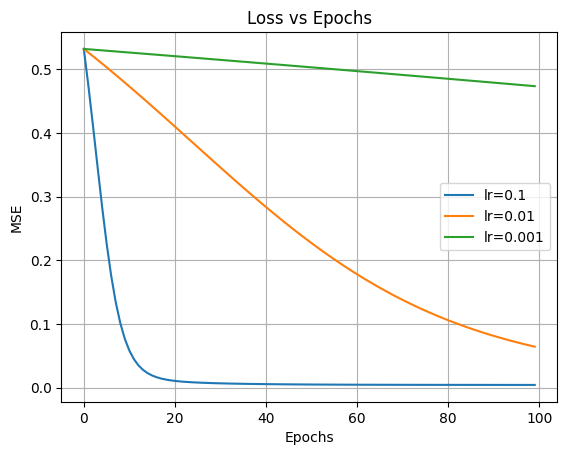

In [4]:
epochs = 100
l_rates = [0.1, 0.01, 0.001]

slp = SimplePerceptron()
preds: Dict[float, List[float]] = dict()
losses_gd: Dict[float, List[float]] = dict()
w_b_gd: Dict[float, Tuple[List[float], List[float]]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, targets=target, epochs=epochs, lr=lr, checkpoint=False)
    
    losses_gd[lr] = slp.mse.copy()  # Store the losses for each learning rate
    w_b_gd[lr] = slp.w_b  # Store the weights and bias for each learning rate 
    preds[lr] = slp.predict(inputs=input) # Store the preds for each learning rate
    
    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

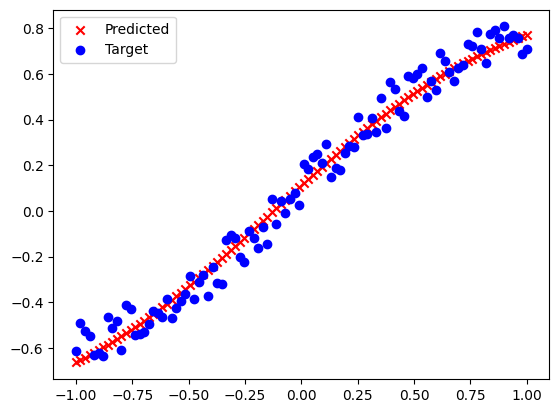

In [5]:
outputs = list()

plt.figure()
plt.scatter(input, preds[0.1], marker='x', color='red')
plt.scatter(input, target, color='blue', marker='o')
plt.legend(['Predicted', 'Target'])
plt.show()

### 1b) Implementación de Adam (1 punto)  
- Implementar el algoritmo de Adam para minimizar \\( J(w, b) \\).  
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Utilizar los mismos valores de \\( w \\) y \\( b \\) que se usaron para GD para cada diferente learning rate.
- Graficar la función de Costo \\( J(w, b) \\) VS número de época
- Hacer 2 modelos, uno sin mini-batch (full-batch) y otro con mini-batch (batch size a elección de ustedes).

\\

Al igual que para GD, el optimizador Adam también se debe implementar desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

Entrenamos usando full batch:

Epoch 1/100, Avg Loss: 0.5321
Epoch 2/100, Avg Loss: 0.2115
Epoch 3/100, Avg Loss: 0.0116
Epoch 4/100, Avg Loss: 0.0760
Epoch 5/100, Avg Loss: 0.1678
Epoch 6/100, Avg Loss: 0.2110
Epoch 7/100, Avg Loss: 0.2143
Epoch 8/100, Avg Loss: 0.1985
Epoch 9/100, Avg Loss: 0.1773
Epoch 10/100, Avg Loss: 0.1573
Epoch 11/100, Avg Loss: 0.1411
Epoch 12/100, Avg Loss: 0.1296
Epoch 13/100, Avg Loss: 0.1230
Epoch 14/100, Avg Loss: 0.1213
Epoch 15/100, Avg Loss: 0.1235
Epoch 16/100, Avg Loss: 0.1276
Epoch 17/100, Avg Loss: 0.1303
Epoch 18/100, Avg Loss: 0.1270
Epoch 19/100, Avg Loss: 0.1136
Epoch 20/100, Avg Loss: 0.0892
Epoch 21/100, Avg Loss: 0.0583
Epoch 22/100, Avg Loss: 0.0296
Epoch 23/100, Avg Loss: 0.0146
Epoch 24/100, Avg Loss: 0.0228
Epoch 25/100, Avg Loss: 0.0465
Epoch 26/100, Avg Loss: 0.0526
Epoch 27/100, Avg Loss: 0.0319
Epoch 28/100, Avg Loss: 0.0164
Epoch 29/100, Avg Loss: 0.0189
Epoch 30/100, Avg Loss: 0.0226
Epoch 31/100, Avg Loss: 0.0206
Epoch 32/100, Avg Loss: 0.0184
Epoch 33/100, Avg

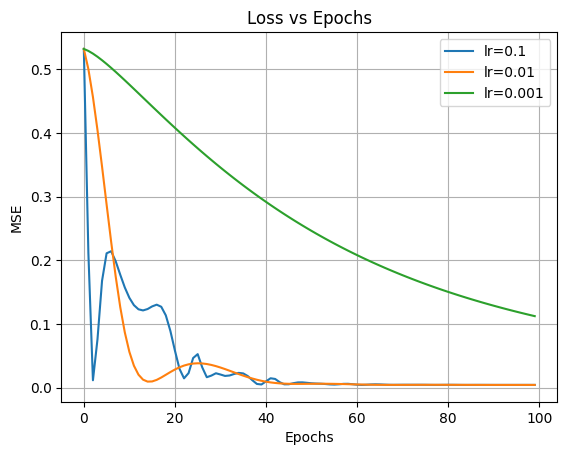

In [6]:
epochs = 100
l_rates = [0.1, 0.01, 0.001]

slp = SimplePerceptron()
losses_adam_fb: Dict[float, List[float]] = dict()
w_b_adam_fb: Dict[float, List[Tuple[float, float]]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, 
        targets=target, 
        epochs=epochs, 
        lr=lr,
        checkpoint=False, 
        optim='adam')
    losses_adam_fb[lr] = slp.mse.copy()
    w_b_adam_fb[lr] = slp.w_b

    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

Adam con minibatch de N muestras:

Epoch 1/100, Avg Loss: 0.3241
Epoch 2/100, Avg Loss: 0.4287
Epoch 3/100, Avg Loss: 0.3151
Epoch 4/100, Avg Loss: 0.2497
Epoch 5/100, Avg Loss: 0.2232
Epoch 6/100, Avg Loss: 0.2228
Epoch 7/100, Avg Loss: 0.2233
Epoch 8/100, Avg Loss: 0.2189
Epoch 9/100, Avg Loss: 0.2096
Epoch 10/100, Avg Loss: 0.1969
Epoch 11/100, Avg Loss: 0.1821
Epoch 12/100, Avg Loss: 0.1651
Epoch 13/100, Avg Loss: 0.1434
Epoch 14/100, Avg Loss: 0.1123
Epoch 15/100, Avg Loss: 0.0650
Epoch 16/100, Avg Loss: 0.0142
Epoch 17/100, Avg Loss: 0.0298
Epoch 18/100, Avg Loss: 0.0070
Epoch 19/100, Avg Loss: 0.0106
Epoch 20/100, Avg Loss: 0.0106
Epoch 21/100, Avg Loss: 0.0060
Epoch 22/100, Avg Loss: 0.0066
Epoch 23/100, Avg Loss: 0.0043
Epoch 24/100, Avg Loss: 0.0047
Epoch 25/100, Avg Loss: 0.0050
Epoch 26/100, Avg Loss: 0.0047
Epoch 27/100, Avg Loss: 0.0046
Epoch 28/100, Avg Loss: 0.0043
Epoch 29/100, Avg Loss: 0.0044
Epoch 30/100, Avg Loss: 0.0045
Epoch 31/100, Avg Loss: 0.0045
Epoch 32/100, Avg Loss: 0.0044
Epoch 33/100, Avg

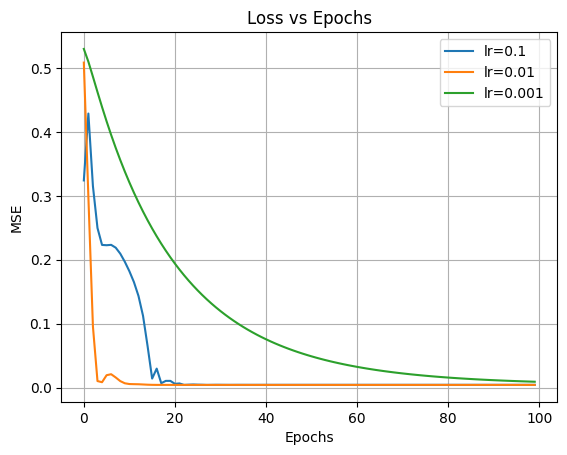

In [7]:
batch_size = 20

losses_adam_mb: Dict[float, List[float]] = dict()
w_b_adam_mb: Dict[float, List[Tuple[float, float]]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, 
        targets=target, 
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        checkpoint=False, 
        optim='adam')
    
    # Store the loss for each learning rate
    losses_adam_mb[lr] = slp.mse.copy()
    w_b_adam_mb[lr] = slp.w_b  # Store the weights and bias for each learning rate    

    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

### 1c) Comparativa de optimizadores (0.5 puntos)  
- Comparar el resultado y rendimiento de GD VS Adam (full-batch) VS Adam (mini-batch) para cada uno de los learning rates.
- Redactar conclusiones analíticas que resalten las diferencias entre cada optimizador.

Gradient Descent vs Adam (full-batch):

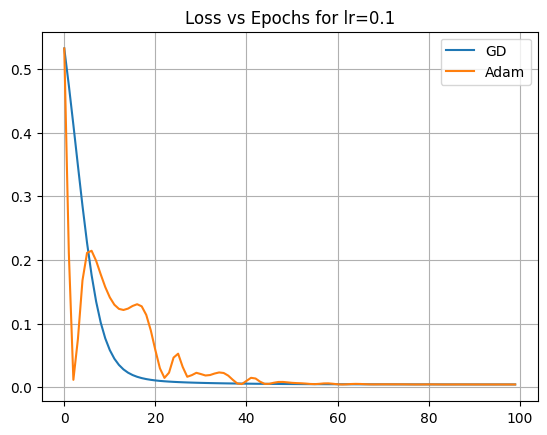

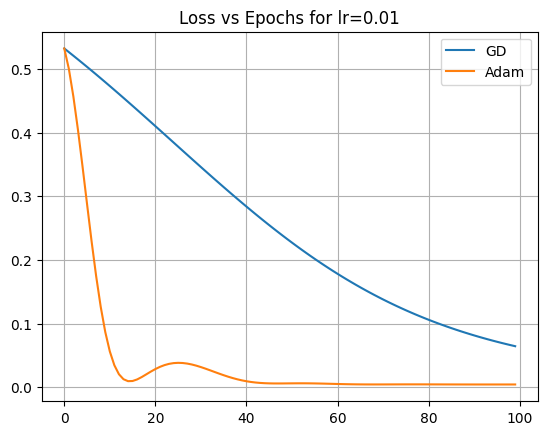

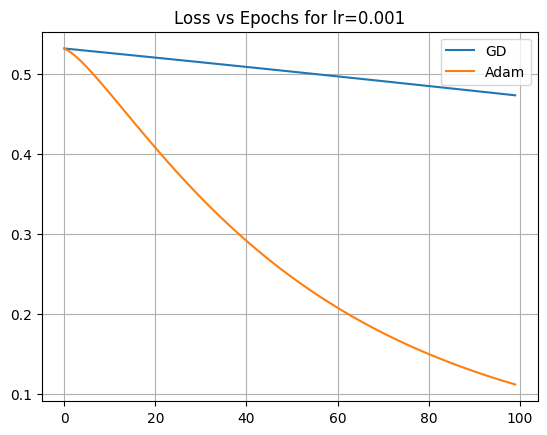

In [8]:
# reutilizamos los curvas de loss obtenidas en los items previos y graficamos
# de a pares:

for lr in l_rates:
    plt.plot(losses_gd[lr], label=f'GD lr={lr}')
    plt.plot(losses_adam_fb[lr], label=f'Adam')
    plt.title(f'Loss vs Epochs for lr={lr}')
    plt.legend(['GD', 'Adam'])
    plt.grid()
    plt.show()
    

Para valores de learning rate de 0.1 y 0.01 no se ven diferencias significativas
en el comportamiento de los optimizadores. Sin embargo, para un learning rate de 0.001, Adam alcanza un mínimo más bajo (para la misma cantidad de epochs) y más rápido que el Gradiente Descendente, lo que indica una mayor eficiencia en la convergencia. 

Gradient Descent vs Adam (mini-batch):

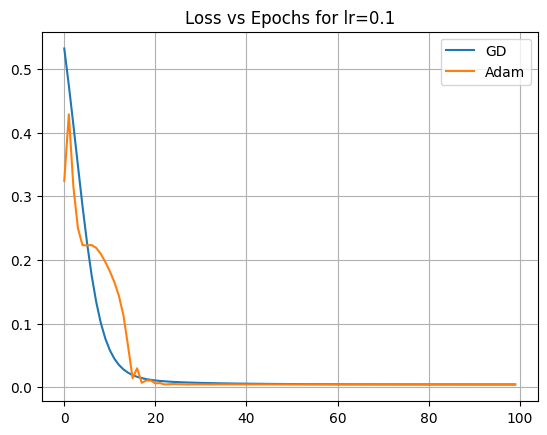

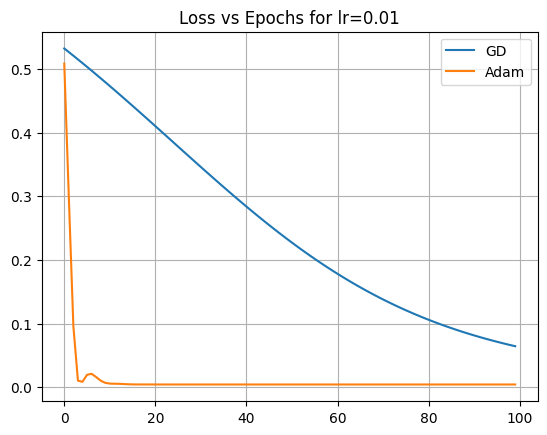

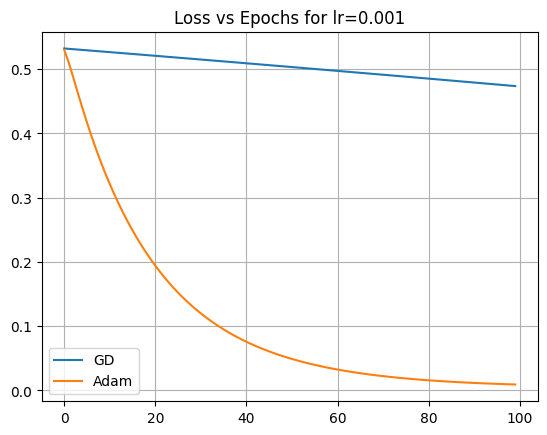

In [9]:
# ajustamos los ejes de los graficos para capturar mejor las diferencias
    
plt.figure()
plt.plot(losses_gd[0.1], label=f'GD lr={lr}')
plt.plot(losses_adam_mb[0.1], label=f'Adam')
plt.title(f'Loss vs Epochs for lr={0.1}')
plt.legend(['GD', 'Adam'])
#plt.ylim(0, 0.01)
#plt.xlim(0, 40)  
plt.grid()
plt.show()

plt.figure()
plt.plot(losses_gd[0.01], label=f'GD lr={lr}')
plt.plot(losses_adam_mb[0.01], label=f'Adam')
plt.title(f'Loss vs Epochs for lr={0.01}')
plt.legend(['GD', 'Adam'])
#plt.ylim(0, 0.02)
#plt.xlim(0, 40)  
plt.grid()
plt.show()

plt.figure()
plt.plot(losses_gd[0.001], label=f'GD lr={lr}')
plt.plot(losses_adam_mb[0.001], label=f'Adam')
plt.title(f'Loss vs Epochs for lr={0.001}')
plt.legend(['GD', 'Adam'])
#plt.ylim(0, 0.01)
# plt.xlim(0, 40)  
plt.grid()
plt.show()

Para el caso del mini-batch, se observa que Adam alcanza una loss mas alta para 
learning rates de 0.1 y 0.01, pero converge más rápido que el Gradiente Descendente. Para un learning rate de 0.001, Adam muestra una convergencia más eficiente que el Gradiente Descendente, alcanzando un mínimo más bajo en menos épocas.

### 1d) Visualización en 3D de la trayectoria de aprendizaje (0.5 puntos)
- Graficar en 3D la trayectoria del aprendizaje de los 3 optimizadores sobre la superficie de la función de costo \\( J(w, b) \\). Se debe elegir un solo learning rate.
- Comparar y redactar cómo se mueven en el espacio de parámetros y qué diferencias existen en la convergencia.
- Recomiendo utilizar `mpl_toolkits.mplot3d` y `np.meshgrid`, pero queda a su criterio la elección de funciones a usar para lograr el gráfico.

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def compute_loss(w, b, X, y):
    y_pred = X * w + b
    return np.mean((y - y_pred) ** 2)

def plot_loss_surface(X, y, w_b, loss_history, title = ''):
    """
    Plots the loss surface for the given weights and bias.
    
    Parameters
    ----------
    X: np.ndarray
        Input data.
    y: np.ndarray
        Target data.
    w_b: Tuple[List[float], List[float]]
        Weights and bias history.
    """
    # create the parameters grid
    weights, bias = w_b

    w_min, w_max = -2 * max(weights), 2 * max(weights)
    b_min, b_max = -2 * max(bias), 2 * max(bias)

    w_vals = np.linspace(w_min, w_max, 100)
    b_vals = np.linspace(b_min, b_max, 100)
    W, B = np.meshgrid(w_vals, b_vals)

    Z = np.array([[compute_loss(w, b, X, y) for w in w_vals] for b in b_vals])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(weights, bias, loss_history, color='red', marker='o', label='Training trajectory', markersize=1)
    # Plot loss surface
    ax.plot_surface(W, B, Z, cmap='viridis', alpha=0.7)
    ax.set_xlabel('Weights')
    ax.set_ylabel('Bias')
    ax.set_zlabel('Loss')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

Como la funcion costo toma valores muy pequeños durante el entrenamiento se grafica solo una porcion de la superficie para que se pueda ver la trayectoria de los optimizadores.

In [12]:
# descomentar para visualizar en ventana externa
%matplotlib qt 

selected_lr = 0.01

for title, wb, losses in zip(
    ['GD', 'Adam (full batch)', 'Adam (mini-batch)'],
    [w_b_gd[selected_lr], w_b_adam_fb[selected_lr], w_b_adam_mb[selected_lr]],
    [losses_gd[selected_lr], losses_adam_fb[selected_lr], losses_adam_mb[selected_lr]]):

    plot_loss_surface(input, target, wb, losses, title=title)

# **PREGUNTA 2**

Descargar el dataset del siguiente link: https://drive.google.com/file/d/147YyKAiQhJhZV9tHAkrgcTzvRgmwB-OX/view?usp=sharing.

El dataset consiste en compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones, compuestas por un cliente y el producto que adquirió.


### 2a) EDA y preparación del dataset (2.5 puntos)
Realizar el análisis exploratorio del dataset (EDA) con las herramientas vistas en materias anteriores. Pre-procesar y transformar las variables que sean necesarias, analizar qué columnas se deben dropear, cuáles vale la pena hacer un tratamiento de valores nulos, si se debe usar label encoding, one-hot encoding o mapping encoding, explicar los criterios utilizados y analizar las distribuciones.

Vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece a un segmento: "Casual" (gasta menos de 3000), "Gama media" (gasta entre 3000 y 8000), "Gama alta" (gasta entre 8000 y 18000) o a "Premium" (gasta más de 18000), según el producto que adquirió.

Redactar las conclusiones preliminares que pueden notar de las columnas y justificar el porqué de cada encoding aplicado.

**IMPORTANTE: Luego de asignar los segmentos, no se olviden de eliminar la columna "Purchase".**

In [13]:
import pandas as pd

DATA_PATH = './dataset_compras.csv'
# Load the dataset
df = pd.read_csv(DATA_PATH)

df.head()

,User_ID,Product_ID,Age,Gender,Marital_Status,City_Category,Stay_In_Current_City_Years,Product_Category,Product_Subcategory_1,Product_Subcategory_2,Purchase
0,1044096,P00017122,46-50,F,1,B,1,10,45.0,NaN,1810
1,1071818,P00074517,36-45,M,0,A,3,11,27.0,NaN,12351
2,1022986,P00013694,36-45,M,1,A,5+,4,28.0,NaN,127
3,1094684,P00049122,36-45,M,1,A,1,16,9.0,8.0,2214
4,1004157,P00006469,46-50,M,1,A,5+,3,NaN,NaN,7142


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182721 entries, 0 to 182720
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     182721 non-null  int64  
 1   Product_ID                  182721 non-null  object 
 2   Age                         182721 non-null  object 
 3   Gender                      182721 non-null  object 
 4   Marital_Status              182721 non-null  int64  
 5   City_Category               182721 non-null  object 
 6   Stay_In_Current_City_Years  182721 non-null  object 
 7   Product_Category            182721 non-null  int64  
 8   Product_Subcategory_1       140903 non-null  float64
 9   Product_Subcategory_2       77461 non-null   float64
 10  Purchase                    182721 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 15.3+ MB


Cantidad de datos faltantes por columna:

In [15]:
print(df.isnull().sum())

User_ID                            0
Product_ID                         0
Age                                0
Gender                             0
Marital_Status                     0
City_Category                      0
Stay_In_Current_City_Years         0
Product_Category                   0
Product_Subcategory_1          41818
Product_Subcategory_2         105260
Purchase                           0
dtype: int64


Filtrado del dataset:

Vemos que el dataset tiene 182721 columnas. La columna `Product_Subcategory_2` contiene 105260 valores nulos, lo que significa que mas del 57% de sus filas tienen datos faltantes. Al tratarse de un identificador de producto no es una informacion que se pueda estimar a partir de datos existentes, por lo tanto, se decide eliminar esta columna. 

Para el caso de la columna `Product_Subcategory_1`, que tiene 41818 valores nulos, se decide eliminarla ya que tambien tienen un 22% de datos faltantes y se espera que el modelo pueda aprender y generalizar a partir de la columna `Product_Category` que no posee datos faltantes.

Se asume que la columna `User_ID` es un identificador aleatorio único de cada usuario y no tendria mucho sentido considerarla para el entrenamiento ya que al realizar clasificacion en datos de produccion, por fuera del dataset, los ids serian diferentes y su valor no tendria relacion con la compra realizada.

In [16]:
df.drop(
    columns=['Product_Subcategory_2', 
             'Product_Subcategory_1', 
             'User_ID',
             'Product_ID'], inplace=True)

In [17]:
# Iterate over columns and print unique values for each
for col in df.columns:
    print(f"{col}: {len(df[col].unique())} unique values")

Age: 7 unique values
Gender: 2 unique values
Marital_Status: 2 unique values
City_Category: 3 unique values
Stay_In_Current_City_Years: 5 unique values
Product_Category: 20 unique values
Purchase: 1833 unique values


Transformamos la columna target `Purchase` en segmentos de clientes, y las columnas `Product_category`, `Gender`, `Stay_In_Current_City_Years`, `City_Category` las transformamos a one-hot encoding.

In [18]:
# Assign segments based on the value of 'Purchase'
def assign_segment(purchase):
    if purchase < 3000:
        return 0
    elif 3000 <= purchase < 8000:
        return 1
    elif 8000 <= purchase < 18000:
        return 3
    else:  # purchase >= 18000
        return 4

target_df = df['Purchase'].apply(assign_segment)
df.drop(columns=['Purchase'], inplace=True)

Aplicamos one-hot encoding a todas las columnas categóricas:


In [19]:
df = pd.get_dummies(df, columns=df.columns, drop_first=True)

# transformo el target, drop_first=False para mantener todas las columnas
# ya que va a ser el target de la red neuronal
target_df = target_df.to_frame(name='target')
target_df_cat = pd.get_dummies(target_df, columns=target_df.columns, drop_first=False)


In [20]:
# guardo el dataset con variables categóricas transformadas
df = pd.concat([df, target_df_cat], axis=1)
df.to_csv('dataset_compras_one_hot.csv', index=False)
df.head()

,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Gender_M,Marital_Status_1,City_Category_B,City_Category_C,...,Product_Category_15,Product_Category_16,Product_Category_17,Product_Category_18,Product_Category_19,Product_Category_20,target_0,target_1,target_3,target_4
0,False,False,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,True,False,False,False,True,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,True,False,False,False,True,True,False,False,...,False,True,False,False,False,False,True,False,False,False
4,False,False,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [1]:
import pandas as pd

df = pd.read_csv('dataset_compras_one_hot.csv')

target_cols = [col for col in df.columns if col.startswith('target_')]
y = df[target_cols].to_numpy()

print(y[0].shape)

(4,)


### 2b) Modelo de deep leaning sin embeddings (1.5 puntos)
Entrenar un modelo de deep learning usando Pytorch que no utilice embeddings, **descartando el `product_id` y `user_id`**. Graficar las evoluciones por época de la función de costo y de métricas como el accuracy y el f1 score para train y validation. Mostrar una matriz de confusión absoluta y otra normalizada por fila. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos.

Pueden usarse herramientas de regularización y prueba de hiperpametros para conseguir mejores resultados.

Un resultado aceptable sería al menos un 77% de accuracy y f1 score para el set de validation.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

In [4]:
class MyDataset(Dataset):

  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv('dataset_compras_one_hot.csv')

target_cols = [col for col in df.columns if col.startswith('target_')]

target = df[target_cols].to_numpy().astype(np.float32)
features = df.drop(columns=target_cols).to_numpy().astype(np.float32)   


In [6]:

dataset = MyDataset(x=features, y=target)
# split in val and train
val_perc = 0.2
train_data, val_data = torch.utils.data.random_split(
    dataset, [1 - val_perc, val_perc])

print(f'Train samples: {len(train_data)}\nTest samples: {len(val_data)}')

Train samples: 146177
Test samples: 36544


In [43]:
# evaluation method
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(model, data_loader, device):
    """
    computes accuracy ad F1 score for the model on the given data loader.
    """

    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predicted class (argmax over output probabilities)
            _, preds = torch.max(outputs, dim=1)
            
            # convert target to index
            label_classes = torch.argmax(labels, dim=1)

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label_classes.cpu().numpy())

    # Compute accuracy and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Use 'weighted' for multi-class F1

    return accuracy, f1

Definimos un modelo para usar de baseline sin embeddings, con una salida de 4 clases, una para cada segmento de cliente.

In [39]:
from torch import nn
from typing import List, Literal, Union



# Arquitectura del modelo sin embeddings
class BaseNet(torch.nn.Module):

  def __init__(
      self, 
      input_features: int = 36,
      dense_layers: List[int] = [50],  # List of layer sizes 
      n_classes: int = 4,
      dropout_rates: Union[float, List[float]] = 0.1,
      activation: Literal['relu', 'gelu', 'leaky_relu', 'selu', 'silu'] = "gelu",):
    # Defino la arquitectura de la red
    super().__init__()
    
    self.input_dim = input_features
    in_features = self.input_dim

    self.activation = self._get_activation(activation)
    # Process dropout rates
    if isinstance(dropout_rates, float):
      self.dropout_rates = [dropout_rates] * len(dense_layers)
    else:
      if len(dropout_rates) != len(dense_layers):
        raise ValueError("dropout_rates must match length of dense_layers")
      self.dropout_rates = dropout_rates

    # Create dense blocks
    self.dense_blocks = nn.ModuleList()
    for i, out_features in enumerate(dense_layers):
      block = nn.ModuleDict()
            
      # Linear layer
      block['linear'] = nn.Linear(in_features, out_features)

            
      # Dropout
      block['dropout'] = nn.Dropout(self.dropout_rates[i])   
      self.dense_blocks.append(block)
      in_features = out_features
        
    # Final output layer
    self.output_layer = nn.Linear(in_features, n_classes)

  def _get_activation(self, activation: str) -> nn.Module:
    activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'leaky_relu': nn.LeakyReLU(),
            'selu': nn.SELU(),
            'silu': nn.SiLU()
        }
    return activations.get(activation.lower(), nn.GELU())

  def forward(self, x):
    # Process through dense blocks
    for block in self.dense_blocks:
      x = block['linear'](x)
            
      if 'norm' in block:
        x = block['norm'](x)          
      x = self.activation(x)
      x = block['dropout'](x)
        
    # Final output
    x = self.output_layer(x)
    return x

In [29]:
model = BaseNet(
    input_features=features.shape[1], 
    n_classes=target.shape[1],
    dropout_rates=[0.2, 0.1, 0.1],
    dense_layers=[128, 64, 32])
print(summary(model, input_size=(1, features.shape[1])))

Layer (type:depth-idx)                   Output Shape              Param #
BaseNet                                  [1, 4]                    --
├─ModuleList: 1-7                        --                        (recursive)
│    └─ModuleDict: 2-2                   --                        (recursive)
│    │    └─Linear: 3-1                  [1, 128]                  4,352
├─GELU: 1-2                              [1, 128]                  --
├─ModuleList: 1-7                        --                        (recursive)
│    └─ModuleDict: 2-2                   --                        (recursive)
│    │    └─Dropout: 3-2                 [1, 128]                  --
│    └─ModuleDict: 2-4                   --                        (recursive)
│    │    └─Linear: 3-3                  [1, 64]                   8,256
├─GELU: 1-4                              [1, 64]                   --
├─ModuleList: 1-7                        --                        (recursive)
│    └─ModuleDict: 2-4   

Training loop

In [30]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# device = "mps" if torch.backends.mps.is_available() else "cpu"

model.to(device)
print(f'running on device: {device}')

loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=0.001)

EPOCHS = 100
BATCH_SIZE = 64

# Creamos un DataLoader para iterar sobre el dataset
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

running on device: cuda:0


In [45]:
from tqdm import tqdm

train_loss_avg = list()
validation_loss_avg = list()

train_acc_list = list()
train_f1_list = list()
val_acc_list = list()
val_f1_list = list()

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss_avg.append(0)
    num_batches = 0
    
    for inputs, targets in tqdm(train_loader):

        inputs, targets = inputs.to(device), targets.to(device)  # Move to device

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss_value = loss(outputs, targets)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        train_loss_avg[-1] += loss_value.item()
        num_batches += 1   
    train_loss_avg[-1] /= num_batches

    # metrics computation

    # train
    train_acc, train_f1 = compute_metrics(model, train_loader, device)
    # validation
    val_acc, val_f1 = compute_metrics(
        model, DataLoader(val_data, batch_size=BATCH_SIZE), device)
    
    # append per epoch data for plotting
    train_acc_list.append(train_acc)
    train_f1_list.append(train_f1)
    val_acc_list.append(val_acc)
    val_f1_list.append(val_f1)

    # Validation loss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients for validation
        num_batches = 0
        validation_loss_avg.append(0)

        for inputs, targets in DataLoader(val_data, batch_size=BATCH_SIZE):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            validation_loss_avg[-1] += loss(outputs, targets).item()
            num_batches += 1
        validation_loss_avg[-1] /= num_batches
    print(f"Epoch {epoch+1}, Train loss: {train_loss_avg[-1]:.4f} Val Loss: {validation_loss_avg[-1]:.4f}")
    print(f"Train Acc: {train_acc:.4f} Train F1: {train_f1:.4f} Val Acc: {val_acc:.4f} Val F1: {val_f1:.4f}")

  0%|          | 0/2285 [00:00<?, ?it/s]

100%|██████████| 2285/2285 [00:03<00:00, 759.20it/s]


Epoch 1, Train loss: 0.2296 Val Loss: 0.2270
Train Acc: 0.7640 Train F1: 0.7567 Val Acc: 0.7651 Val F1: 0.7583


100%|██████████| 2285/2285 [00:02<00:00, 775.43it/s]


Epoch 2, Train loss: 0.2293 Val Loss: 0.2271
Train Acc: 0.7638 Train F1: 0.7568 Val Acc: 0.7638 Val F1: 0.7573


100%|██████████| 2285/2285 [00:02<00:00, 783.00it/s]


Epoch 3, Train loss: 0.2292 Val Loss: 0.2273
Train Acc: 0.7639 Train F1: 0.7567 Val Acc: 0.7660 Val F1: 0.7594


100%|██████████| 2285/2285 [00:02<00:00, 775.91it/s]


Epoch 4, Train loss: 0.2293 Val Loss: 0.2277
Train Acc: 0.7640 Train F1: 0.7571 Val Acc: 0.7649 Val F1: 0.7586


100%|██████████| 2285/2285 [00:02<00:00, 774.88it/s]


Epoch 5, Train loss: 0.2294 Val Loss: 0.2271
Train Acc: 0.7637 Train F1: 0.7567 Val Acc: 0.7669 Val F1: 0.7605


100%|██████████| 2285/2285 [00:02<00:00, 772.00it/s]


Epoch 6, Train loss: 0.2293 Val Loss: 0.2271
Train Acc: 0.7642 Train F1: 0.7574 Val Acc: 0.7634 Val F1: 0.7572


100%|██████████| 2285/2285 [00:03<00:00, 754.18it/s]


Epoch 7, Train loss: 0.2293 Val Loss: 0.2270
Train Acc: 0.7638 Train F1: 0.7569 Val Acc: 0.7656 Val F1: 0.7594


100%|██████████| 2285/2285 [00:02<00:00, 769.43it/s]


Epoch 8, Train loss: 0.2292 Val Loss: 0.2272
Train Acc: 0.7639 Train F1: 0.7573 Val Acc: 0.7662 Val F1: 0.7603


100%|██████████| 2285/2285 [00:03<00:00, 754.15it/s]


Epoch 9, Train loss: 0.2295 Val Loss: 0.2270
Train Acc: 0.7639 Train F1: 0.7572 Val Acc: 0.7651 Val F1: 0.7589


100%|██████████| 2285/2285 [00:03<00:00, 743.62it/s]


Epoch 10, Train loss: 0.2292 Val Loss: 0.2272
Train Acc: 0.7641 Train F1: 0.7572 Val Acc: 0.7631 Val F1: 0.7569


100%|██████████| 2285/2285 [00:03<00:00, 753.94it/s]


Epoch 11, Train loss: 0.2293 Val Loss: 0.2271
Train Acc: 0.7642 Train F1: 0.7574 Val Acc: 0.7649 Val F1: 0.7587


100%|██████████| 2285/2285 [00:02<00:00, 810.58it/s]


Epoch 12, Train loss: 0.2292 Val Loss: 0.2271
Train Acc: 0.7639 Train F1: 0.7569 Val Acc: 0.7639 Val F1: 0.7573


100%|██████████| 2285/2285 [00:02<00:00, 817.49it/s]


Epoch 13, Train loss: 0.2291 Val Loss: 0.2276
Train Acc: 0.7639 Train F1: 0.7563 Val Acc: 0.7646 Val F1: 0.7577


100%|██████████| 2285/2285 [00:02<00:00, 774.68it/s]


Epoch 14, Train loss: 0.2294 Val Loss: 0.2270
Train Acc: 0.7639 Train F1: 0.7570 Val Acc: 0.7653 Val F1: 0.7592


100%|██████████| 2285/2285 [00:03<00:00, 760.79it/s]


Epoch 15, Train loss: 0.2293 Val Loss: 0.2270
Train Acc: 0.7641 Train F1: 0.7579 Val Acc: 0.7645 Val F1: 0.7590


100%|██████████| 2285/2285 [00:03<00:00, 751.23it/s]


Epoch 16, Train loss: 0.2292 Val Loss: 0.2271
Train Acc: 0.7634 Train F1: 0.7564 Val Acc: 0.7639 Val F1: 0.7578


100%|██████████| 2285/2285 [00:03<00:00, 750.21it/s]


Epoch 17, Train loss: 0.2293 Val Loss: 0.2271
Train Acc: 0.7634 Train F1: 0.7575 Val Acc: 0.7665 Val F1: 0.7611


100%|██████████| 2285/2285 [00:03<00:00, 704.97it/s]


Epoch 18, Train loss: 0.2292 Val Loss: 0.2273
Train Acc: 0.7636 Train F1: 0.7565 Val Acc: 0.7650 Val F1: 0.7585


100%|██████████| 2285/2285 [00:02<00:00, 792.72it/s]


Epoch 19, Train loss: 0.2292 Val Loss: 0.2273
Train Acc: 0.7637 Train F1: 0.7570 Val Acc: 0.7632 Val F1: 0.7572


100%|██████████| 2285/2285 [00:02<00:00, 819.33it/s]


Epoch 20, Train loss: 0.2291 Val Loss: 0.2270
Train Acc: 0.7632 Train F1: 0.7562 Val Acc: 0.7652 Val F1: 0.7587


100%|██████████| 2285/2285 [00:02<00:00, 803.18it/s]


Epoch 21, Train loss: 0.2291 Val Loss: 0.2275
Train Acc: 0.7635 Train F1: 0.7567 Val Acc: 0.7647 Val F1: 0.7587


100%|██████████| 2285/2285 [00:02<00:00, 795.40it/s]


Epoch 22, Train loss: 0.2293 Val Loss: 0.2269
Train Acc: 0.7638 Train F1: 0.7566 Val Acc: 0.7652 Val F1: 0.7584


100%|██████████| 2285/2285 [00:02<00:00, 827.50it/s]


Epoch 23, Train loss: 0.2294 Val Loss: 0.2273
Train Acc: 0.7641 Train F1: 0.7567 Val Acc: 0.7646 Val F1: 0.7578


100%|██████████| 2285/2285 [00:02<00:00, 783.76it/s]


Epoch 24, Train loss: 0.2293 Val Loss: 0.2274
Train Acc: 0.7639 Train F1: 0.7569 Val Acc: 0.7631 Val F1: 0.7566


100%|██████████| 2285/2285 [00:02<00:00, 765.10it/s]


Epoch 25, Train loss: 0.2291 Val Loss: 0.2271
Train Acc: 0.7637 Train F1: 0.7571 Val Acc: 0.7649 Val F1: 0.7591


100%|██████████| 2285/2285 [00:02<00:00, 767.21it/s]


Epoch 26, Train loss: 0.2295 Val Loss: 0.2273
Train Acc: 0.7641 Train F1: 0.7583 Val Acc: 0.7658 Val F1: 0.7605


100%|██████████| 2285/2285 [00:03<00:00, 721.95it/s]


Epoch 27, Train loss: 0.2291 Val Loss: 0.2270
Train Acc: 0.7640 Train F1: 0.7572 Val Acc: 0.7658 Val F1: 0.7597


100%|██████████| 2285/2285 [00:02<00:00, 788.66it/s]


Epoch 28, Train loss: 0.2292 Val Loss: 0.2274
Train Acc: 0.7639 Train F1: 0.7575 Val Acc: 0.7640 Val F1: 0.7582


100%|██████████| 2285/2285 [00:03<00:00, 746.82it/s]


Epoch 29, Train loss: 0.2295 Val Loss: 0.2272
Train Acc: 0.7632 Train F1: 0.7547 Val Acc: 0.7625 Val F1: 0.7547


100%|██████████| 2285/2285 [00:03<00:00, 746.58it/s]


Epoch 30, Train loss: 0.2292 Val Loss: 0.2272
Train Acc: 0.7638 Train F1: 0.7583 Val Acc: 0.7658 Val F1: 0.7606


100%|██████████| 2285/2285 [00:03<00:00, 742.66it/s]


Epoch 31, Train loss: 0.2293 Val Loss: 0.2271
Train Acc: 0.7640 Train F1: 0.7577 Val Acc: 0.7654 Val F1: 0.7596


100%|██████████| 2285/2285 [00:03<00:00, 721.37it/s]


Epoch 32, Train loss: 0.2294 Val Loss: 0.2275
Train Acc: 0.7636 Train F1: 0.7565 Val Acc: 0.7641 Val F1: 0.7578


100%|██████████| 2285/2285 [00:03<00:00, 719.24it/s]


Epoch 33, Train loss: 0.2292 Val Loss: 0.2272
Train Acc: 0.7634 Train F1: 0.7565 Val Acc: 0.7637 Val F1: 0.7576


100%|██████████| 2285/2285 [00:03<00:00, 720.33it/s]


Epoch 34, Train loss: 0.2291 Val Loss: 0.2273
Train Acc: 0.7640 Train F1: 0.7580 Val Acc: 0.7653 Val F1: 0.7596


100%|██████████| 2285/2285 [00:03<00:00, 750.95it/s]


Epoch 35, Train loss: 0.2292 Val Loss: 0.2273
Train Acc: 0.7632 Train F1: 0.7539 Val Acc: 0.7623 Val F1: 0.7536


100%|██████████| 2285/2285 [00:03<00:00, 758.95it/s]


Epoch 36, Train loss: 0.2292 Val Loss: 0.2271
Train Acc: 0.7639 Train F1: 0.7566 Val Acc: 0.7658 Val F1: 0.7591


100%|██████████| 2285/2285 [00:03<00:00, 732.83it/s]


Epoch 37, Train loss: 0.2293 Val Loss: 0.2277
Train Acc: 0.7629 Train F1: 0.7556 Val Acc: 0.7605 Val F1: 0.7537


100%|██████████| 2285/2285 [00:03<00:00, 731.42it/s]


Epoch 38, Train loss: 0.2292 Val Loss: 0.2270
Train Acc: 0.7641 Train F1: 0.7572 Val Acc: 0.7651 Val F1: 0.7587


100%|██████████| 2285/2285 [00:03<00:00, 748.73it/s]


Epoch 39, Train loss: 0.2290 Val Loss: 0.2274
Train Acc: 0.7627 Train F1: 0.7546 Val Acc: 0.7620 Val F1: 0.7545


100%|██████████| 2285/2285 [00:03<00:00, 724.40it/s]


Epoch 40, Train loss: 0.2292 Val Loss: 0.2270
Train Acc: 0.7640 Train F1: 0.7573 Val Acc: 0.7657 Val F1: 0.7594


100%|██████████| 2285/2285 [00:03<00:00, 735.93it/s]


Epoch 41, Train loss: 0.2291 Val Loss: 0.2273
Train Acc: 0.7636 Train F1: 0.7571 Val Acc: 0.7671 Val F1: 0.7610


100%|██████████| 2285/2285 [00:03<00:00, 700.91it/s]


Epoch 42, Train loss: 0.2292 Val Loss: 0.2273
Train Acc: 0.7639 Train F1: 0.7568 Val Acc: 0.7634 Val F1: 0.7571


100%|██████████| 2285/2285 [00:03<00:00, 705.51it/s]


Epoch 43, Train loss: 0.2292 Val Loss: 0.2272
Train Acc: 0.7634 Train F1: 0.7559 Val Acc: 0.7637 Val F1: 0.7566


100%|██████████| 2285/2285 [00:03<00:00, 723.40it/s]


Epoch 44, Train loss: 0.2292 Val Loss: 0.2270
Train Acc: 0.7639 Train F1: 0.7577 Val Acc: 0.7663 Val F1: 0.7605


100%|██████████| 2285/2285 [00:03<00:00, 726.41it/s]


Epoch 45, Train loss: 0.2290 Val Loss: 0.2273
Train Acc: 0.7639 Train F1: 0.7563 Val Acc: 0.7647 Val F1: 0.7576


100%|██████████| 2285/2285 [00:03<00:00, 717.73it/s]


Epoch 46, Train loss: 0.2294 Val Loss: 0.2268
Train Acc: 0.7640 Train F1: 0.7571 Val Acc: 0.7661 Val F1: 0.7597


100%|██████████| 2285/2285 [00:04<00:00, 553.75it/s]


Epoch 47, Train loss: 0.2292 Val Loss: 0.2272
Train Acc: 0.7638 Train F1: 0.7578 Val Acc: 0.7657 Val F1: 0.7603


100%|██████████| 2285/2285 [00:05<00:00, 448.53it/s]


Epoch 48, Train loss: 0.2292 Val Loss: 0.2269
Train Acc: 0.7635 Train F1: 0.7570 Val Acc: 0.7660 Val F1: 0.7599


100%|██████████| 2285/2285 [00:05<00:00, 395.62it/s]


Epoch 49, Train loss: 0.2292 Val Loss: 0.2275
Train Acc: 0.7628 Train F1: 0.7556 Val Acc: 0.7617 Val F1: 0.7553


100%|██████████| 2285/2285 [00:05<00:00, 418.96it/s]


Epoch 50, Train loss: 0.2290 Val Loss: 0.2276
Train Acc: 0.7642 Train F1: 0.7571 Val Acc: 0.7639 Val F1: 0.7574


100%|██████████| 2285/2285 [00:03<00:00, 729.08it/s]


Epoch 51, Train loss: 0.2292 Val Loss: 0.2272
Train Acc: 0.7642 Train F1: 0.7577 Val Acc: 0.7651 Val F1: 0.7592


100%|██████████| 2285/2285 [00:03<00:00, 735.44it/s]


Epoch 52, Train loss: 0.2291 Val Loss: 0.2272
Train Acc: 0.7642 Train F1: 0.7574 Val Acc: 0.7654 Val F1: 0.7591


100%|██████████| 2285/2285 [00:02<00:00, 764.89it/s]


Epoch 53, Train loss: 0.2293 Val Loss: 0.2275
Train Acc: 0.7640 Train F1: 0.7581 Val Acc: 0.7662 Val F1: 0.7607


100%|██████████| 2285/2285 [00:02<00:00, 821.30it/s]


Epoch 54, Train loss: 0.2292 Val Loss: 0.2271
Train Acc: 0.7640 Train F1: 0.7573 Val Acc: 0.7638 Val F1: 0.7576


100%|██████████| 2285/2285 [00:02<00:00, 781.97it/s]


Epoch 55, Train loss: 0.2291 Val Loss: 0.2279
Train Acc: 0.7636 Train F1: 0.7569 Val Acc: 0.7633 Val F1: 0.7574


100%|██████████| 2285/2285 [00:03<00:00, 734.05it/s]


Epoch 56, Train loss: 0.2294 Val Loss: 0.2273
Train Acc: 0.7640 Train F1: 0.7576 Val Acc: 0.7654 Val F1: 0.7596


100%|██████████| 2285/2285 [00:03<00:00, 720.69it/s]


Epoch 57, Train loss: 0.2291 Val Loss: 0.2273
Train Acc: 0.7637 Train F1: 0.7562 Val Acc: 0.7625 Val F1: 0.7556


100%|██████████| 2285/2285 [00:02<00:00, 762.58it/s]


Epoch 58, Train loss: 0.2292 Val Loss: 0.2273
Train Acc: 0.7636 Train F1: 0.7559 Val Acc: 0.7647 Val F1: 0.7574


100%|██████████| 2285/2285 [00:02<00:00, 798.18it/s]


Epoch 59, Train loss: 0.2292 Val Loss: 0.2275
Train Acc: 0.7641 Train F1: 0.7571 Val Acc: 0.7633 Val F1: 0.7568


100%|██████████| 2285/2285 [00:02<00:00, 779.12it/s]


Epoch 60, Train loss: 0.2291 Val Loss: 0.2272
Train Acc: 0.7642 Train F1: 0.7572 Val Acc: 0.7635 Val F1: 0.7572


100%|██████████| 2285/2285 [00:03<00:00, 761.38it/s]


Epoch 61, Train loss: 0.2290 Val Loss: 0.2270
Train Acc: 0.7637 Train F1: 0.7574 Val Acc: 0.7652 Val F1: 0.7593


100%|██████████| 2285/2285 [00:03<00:00, 759.09it/s]


Epoch 62, Train loss: 0.2291 Val Loss: 0.2271
Train Acc: 0.7640 Train F1: 0.7570 Val Acc: 0.7656 Val F1: 0.7591


100%|██████████| 2285/2285 [00:02<00:00, 763.14it/s]


Epoch 63, Train loss: 0.2290 Val Loss: 0.2273
Train Acc: 0.7638 Train F1: 0.7574 Val Acc: 0.7667 Val F1: 0.7607


100%|██████████| 2285/2285 [00:03<00:00, 743.97it/s]


Epoch 64, Train loss: 0.2293 Val Loss: 0.2274
Train Acc: 0.7640 Train F1: 0.7567 Val Acc: 0.7626 Val F1: 0.7559


100%|██████████| 2285/2285 [00:03<00:00, 742.05it/s]


Epoch 65, Train loss: 0.2291 Val Loss: 0.2269
Train Acc: 0.7632 Train F1: 0.7568 Val Acc: 0.7663 Val F1: 0.7603


100%|██████████| 2285/2285 [00:03<00:00, 725.04it/s]


Epoch 66, Train loss: 0.2290 Val Loss: 0.2273
Train Acc: 0.7641 Train F1: 0.7571 Val Acc: 0.7636 Val F1: 0.7572


100%|██████████| 2285/2285 [00:03<00:00, 725.24it/s]


Epoch 67, Train loss: 0.2291 Val Loss: 0.2273
Train Acc: 0.7641 Train F1: 0.7573 Val Acc: 0.7625 Val F1: 0.7563


100%|██████████| 2285/2285 [00:03<00:00, 744.57it/s]


Epoch 68, Train loss: 0.2291 Val Loss: 0.2272
Train Acc: 0.7641 Train F1: 0.7570 Val Acc: 0.7640 Val F1: 0.7575


100%|██████████| 2285/2285 [00:03<00:00, 727.11it/s]


Epoch 69, Train loss: 0.2289 Val Loss: 0.2272
Train Acc: 0.7641 Train F1: 0.7585 Val Acc: 0.7658 Val F1: 0.7606


100%|██████████| 2285/2285 [00:02<00:00, 782.04it/s]


Epoch 70, Train loss: 0.2292 Val Loss: 0.2274
Train Acc: 0.7640 Train F1: 0.7578 Val Acc: 0.7655 Val F1: 0.7599


100%|██████████| 2285/2285 [00:02<00:00, 831.69it/s]


Epoch 71, Train loss: 0.2290 Val Loss: 0.2276
Train Acc: 0.7642 Train F1: 0.7582 Val Acc: 0.7650 Val F1: 0.7596


100%|██████████| 2285/2285 [00:03<00:00, 740.69it/s]


Epoch 72, Train loss: 0.2292 Val Loss: 0.2271
Train Acc: 0.7640 Train F1: 0.7562 Val Acc: 0.7643 Val F1: 0.7572


100%|██████████| 2285/2285 [00:03<00:00, 755.81it/s]


Epoch 73, Train loss: 0.2289 Val Loss: 0.2272
Train Acc: 0.7640 Train F1: 0.7567 Val Acc: 0.7654 Val F1: 0.7587


100%|██████████| 2285/2285 [00:03<00:00, 743.57it/s]


Epoch 74, Train loss: 0.2289 Val Loss: 0.2274
Train Acc: 0.7640 Train F1: 0.7579 Val Acc: 0.7660 Val F1: 0.7603


100%|██████████| 2285/2285 [00:03<00:00, 752.40it/s]


Epoch 75, Train loss: 0.2292 Val Loss: 0.2271
Train Acc: 0.7642 Train F1: 0.7577 Val Acc: 0.7640 Val F1: 0.7579


100%|██████████| 2285/2285 [00:02<00:00, 766.01it/s]


Epoch 76, Train loss: 0.2292 Val Loss: 0.2273
Train Acc: 0.7641 Train F1: 0.7571 Val Acc: 0.7659 Val F1: 0.7594


100%|██████████| 2285/2285 [00:03<00:00, 753.58it/s]


Epoch 77, Train loss: 0.2291 Val Loss: 0.2272
Train Acc: 0.7641 Train F1: 0.7569 Val Acc: 0.7637 Val F1: 0.7569


100%|██████████| 2285/2285 [00:03<00:00, 715.09it/s]


Epoch 78, Train loss: 0.2290 Val Loss: 0.2272
Train Acc: 0.7638 Train F1: 0.7572 Val Acc: 0.7664 Val F1: 0.7601


100%|██████████| 2285/2285 [00:03<00:00, 713.86it/s]


Epoch 79, Train loss: 0.2293 Val Loss: 0.2270
Train Acc: 0.7639 Train F1: 0.7566 Val Acc: 0.7637 Val F1: 0.7571


100%|██████████| 2285/2285 [00:02<00:00, 817.68it/s]


Epoch 80, Train loss: 0.2291 Val Loss: 0.2276
Train Acc: 0.7634 Train F1: 0.7566 Val Acc: 0.7647 Val F1: 0.7580


100%|██████████| 2285/2285 [00:02<00:00, 806.47it/s]


Epoch 81, Train loss: 0.2294 Val Loss: 0.2276
Train Acc: 0.7634 Train F1: 0.7571 Val Acc: 0.7667 Val F1: 0.7608


100%|██████████| 2285/2285 [00:02<00:00, 790.36it/s]


Epoch 82, Train loss: 0.2290 Val Loss: 0.2271
Train Acc: 0.7640 Train F1: 0.7570 Val Acc: 0.7650 Val F1: 0.7586


100%|██████████| 2285/2285 [00:02<00:00, 777.62it/s]


Epoch 83, Train loss: 0.2292 Val Loss: 0.2272
Train Acc: 0.7641 Train F1: 0.7572 Val Acc: 0.7651 Val F1: 0.7586


100%|██████████| 2285/2285 [00:02<00:00, 783.54it/s]


Epoch 84, Train loss: 0.2290 Val Loss: 0.2274
Train Acc: 0.7639 Train F1: 0.7580 Val Acc: 0.7660 Val F1: 0.7604


100%|██████████| 2285/2285 [00:02<00:00, 765.78it/s]


Epoch 85, Train loss: 0.2291 Val Loss: 0.2272
Train Acc: 0.7639 Train F1: 0.7572 Val Acc: 0.7651 Val F1: 0.7587


100%|██████████| 2285/2285 [00:03<00:00, 747.26it/s]


Epoch 86, Train loss: 0.2290 Val Loss: 0.2273
Train Acc: 0.7638 Train F1: 0.7576 Val Acc: 0.7644 Val F1: 0.7589


100%|██████████| 2285/2285 [00:02<00:00, 817.99it/s]


Epoch 87, Train loss: 0.2290 Val Loss: 0.2271
Train Acc: 0.7641 Train F1: 0.7577 Val Acc: 0.7662 Val F1: 0.7605


100%|██████████| 2285/2285 [00:02<00:00, 812.35it/s]


Epoch 88, Train loss: 0.2292 Val Loss: 0.2276
Train Acc: 0.7639 Train F1: 0.7581 Val Acc: 0.7668 Val F1: 0.7613


100%|██████████| 2285/2285 [00:02<00:00, 813.35it/s]


Epoch 89, Train loss: 0.2290 Val Loss: 0.2273
Train Acc: 0.7639 Train F1: 0.7566 Val Acc: 0.7662 Val F1: 0.7595


100%|██████████| 2285/2285 [00:02<00:00, 770.12it/s]


Epoch 90, Train loss: 0.2293 Val Loss: 0.2273
Train Acc: 0.7642 Train F1: 0.7576 Val Acc: 0.7662 Val F1: 0.7600


100%|██████████| 2285/2285 [00:03<00:00, 752.33it/s]


Epoch 91, Train loss: 0.2289 Val Loss: 0.2273
Train Acc: 0.7641 Train F1: 0.7582 Val Acc: 0.7657 Val F1: 0.7602


100%|██████████| 2285/2285 [00:02<00:00, 820.26it/s]


Epoch 92, Train loss: 0.2291 Val Loss: 0.2270
Train Acc: 0.7637 Train F1: 0.7575 Val Acc: 0.7653 Val F1: 0.7595


100%|██████████| 2285/2285 [00:02<00:00, 822.15it/s]


Epoch 93, Train loss: 0.2290 Val Loss: 0.2272
Train Acc: 0.7641 Train F1: 0.7573 Val Acc: 0.7656 Val F1: 0.7592


100%|██████████| 2285/2285 [00:02<00:00, 842.34it/s]


Epoch 94, Train loss: 0.2290 Val Loss: 0.2277
Train Acc: 0.7643 Train F1: 0.7576 Val Acc: 0.7655 Val F1: 0.7592


100%|██████████| 2285/2285 [00:02<00:00, 821.97it/s]


Epoch 95, Train loss: 0.2296 Val Loss: 0.2273
Train Acc: 0.7637 Train F1: 0.7566 Val Acc: 0.7626 Val F1: 0.7563


100%|██████████| 2285/2285 [00:02<00:00, 816.49it/s]


Epoch 96, Train loss: 0.2290 Val Loss: 0.2272
Train Acc: 0.7639 Train F1: 0.7577 Val Acc: 0.7658 Val F1: 0.7601


100%|██████████| 2285/2285 [00:02<00:00, 818.99it/s]


Epoch 97, Train loss: 0.2289 Val Loss: 0.2272
Train Acc: 0.7639 Train F1: 0.7566 Val Acc: 0.7629 Val F1: 0.7561


100%|██████████| 2285/2285 [00:02<00:00, 816.58it/s]


Epoch 98, Train loss: 0.2288 Val Loss: 0.2272
Train Acc: 0.7641 Train F1: 0.7575 Val Acc: 0.7664 Val F1: 0.7603


100%|██████████| 2285/2285 [00:02<00:00, 842.83it/s]


Epoch 99, Train loss: 0.2290 Val Loss: 0.2273
Train Acc: 0.7638 Train F1: 0.7568 Val Acc: 0.7652 Val F1: 0.7589


100%|██████████| 2285/2285 [00:02<00:00, 817.12it/s]


Epoch 100, Train loss: 0.2289 Val Loss: 0.2273
Train Acc: 0.7643 Train F1: 0.7575 Val Acc: 0.7652 Val F1: 0.7588


Graficamos metricas y analisis de resultados

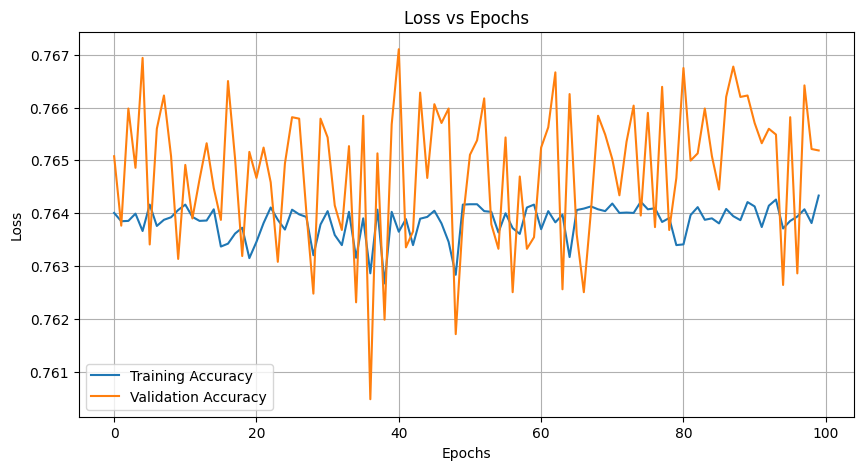

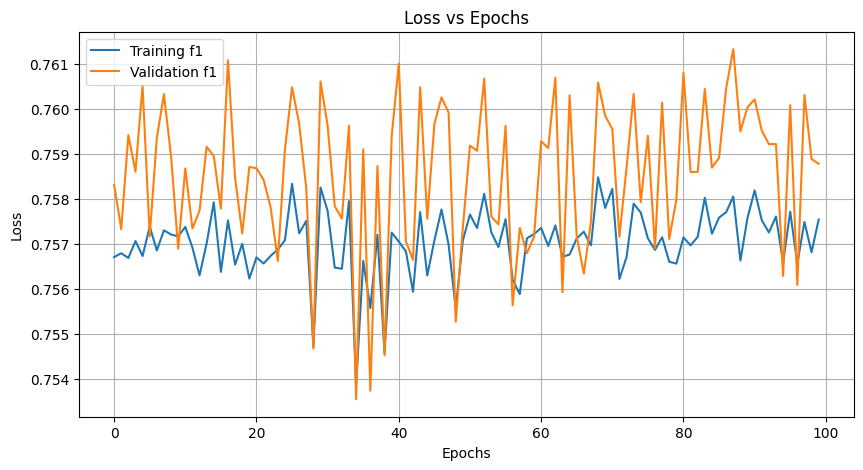

Final Train Accuracy: 0.7643, Final Train F1: 0.7575
Final Validation Accuracy: 0.7652, Final Validation F1: 0.7588


In [47]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_f1_list, label='Training f1')
plt.plot(val_f1_list, label='Validation f1')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

print(f"Final Train Accuracy: {train_acc_list[-1]:.4f}, Final Train F1: {train_f1_list[-1]:.4f}")
print(f'Final Validation Accuracy: {val_acc_list[-1]:.4f}, Final Validation F1: {val_f1_list[-1]:.4f}')

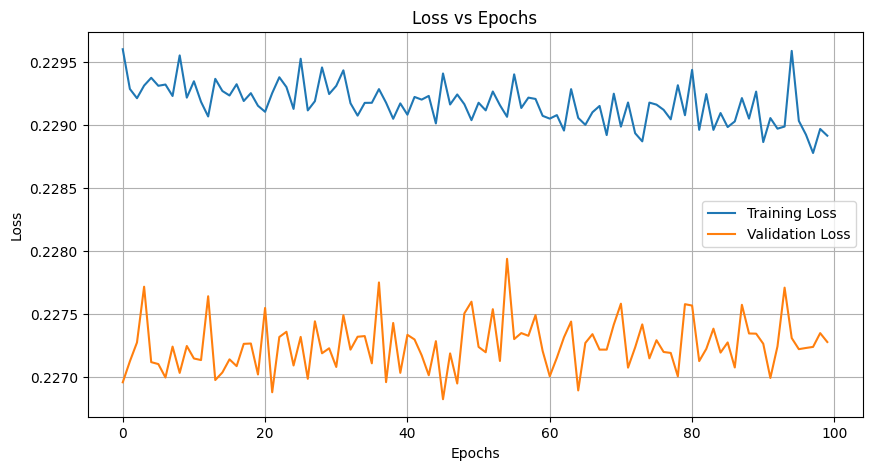

In [48]:

plt.figure(figsize=(10, 5))
plt.plot(train_loss_avg, label='Training Loss')
plt.plot(validation_loss_avg, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# matriz de confusion

### Conclusiones

Se observa que el modelo logra alcanzar las metricas pedidas en el enunciado. Para ello se eligieron mediante heuristica porcentajes de drop out y tamanios de capas fully connected. Como se vio durante las clases teoricas es muy dificil lograr una generalizacion adecuada sin embeddings cuando hay variables con mucha cardinalidad y eso es lo que se ve reflejado en las curvas de loss en funcion de las epochs.

### 2c) Modelo de deep leaning con embeddings (2 puntos)
Entrenar un modelo de deep learning usando Pytorch que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones por época de la función de costo y de métricas como el accuracy y el f1 score para train y test. Mostrar una matriz de confusión absoluta y otra normalizada por fila. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos. Justificar la cantidad de dimensiones usada para los embeddings. **Comparar contra el modelo sin embeddings** y explicar el porqué de los resultados.

Pueden usarse herramientas de regularización y prueba de hiperpametros para conseguir mejores resultados.

Un resultado aceptable sería al menos un 90% de accuracy y f1 score para el set de validation.

In [135]:
# dataset con embeddings
import pandas as pd
dataset_df = pd.read_csv('dataset_compras.csv')

# descartamos las categorias que no son relevantes y la columna target como se vio en el analisis 
# previo pero conservando la columna de User_ID.
dataset_df.drop(
    columns=['Product_Subcategory_2', 
             'Product_Subcategory_1',
             'Purchase',
             'Product_ID'], inplace=True)

dataset_df.head()

,User_ID,Age,Gender,Marital_Status,City_Category,Stay_In_Current_City_Years,Product_Category
0,1044096,46-50,F,1,B,1,10
1,1071818,36-45,M,0,A,3,11
2,1022986,36-45,M,1,A,5+,4
3,1094684,36-45,M,1,A,1,16
4,1004157,46-50,M,1,A,5+,3


In [136]:
# Reemplazamos los valores de la columna User_ID y Product Category por un 
# indice necesario para aplicar embeddings

product2id = {cat: idx for idx, cat in enumerate(dataset_df['Product_Category'].unique())}
user2id = {user: idx for idx, user in enumerate(dataset_df['User_ID'].unique())}

dataset_df['Product_Category'] = dataset_df['Product_Category'].map(product2id).astype('int64')
dataset_df['User_ID'] = dataset_df['User_ID'].map(user2id).astype('int64')

# aplico one hot a las columnas categóricas restantes
cols = [
    'Age', 'Gender', 
    'Marital_Status', 
    'City_Category', 
    'Stay_In_Current_City_Years']
dataset_df = pd.get_dummies(
    dataset_df, columns=cols, drop_first=True)

dataset_df.head()

,User_ID,Product_Category,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Gender_M,Marital_Status_1,City_Category_B,City_Category_C,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4,Stay_In_Current_City_Years_5+
0,0,0,False,False,False,True,False,False,False,True,True,False,False,False,False,False
1,1,1,False,False,True,False,False,False,True,False,False,False,False,True,False,False
2,2,2,False,False,True,False,False,False,True,True,False,False,False,False,False,True
3,3,3,False,False,True,False,False,False,True,True,False,False,False,False,False,False
4,4,4,False,False,False,True,False,False,True,True,False,False,False,False,False,True


In [144]:
dataset_np = dataset_df.to_numpy().astype(np.float32)
# Definimos las columnas de target
USER_ID_COL = 0
PRODUCT_CATEGORY_COL = 1


array([0.000e+00, 1.000e+00, 2.000e+00, ..., 2.676e+03, 1.135e+03,
       4.059e+03], dtype=float32)

In [130]:
from typing import Dict, List, Union, Tuple

# definimos el dataset y el collator
class MyEbdDataset(Dataset):

  def __init__(self, x: pd.DataFrame, y: np.ndarray):
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    to_embed = {
      k: torch.tensor(self.x.loc[idx, k], dtype=torch.long)
      for k in ['User_ID', 'Product_Category']}
    features = {
      k: torch.tensor(self.x.loc[idx, k], dtype=torch.float32)
      for k in self.x.columns if k not in ['User_ID', 'Product_Category']
    }

    return {**to_embed, **features, 'label': torch.tensor(self.y[idx])}

# Data collator
class BBBCollator:
  def __init__(self):
    
    self.to_embed_features = ['User_ID', 'Product_Category']
    
  def __call__(self, batch: List[Dict[str, torch.Tensor]]) -> Tuple[Dict[str, torch.Tensor], torch.Tensor]:
      # Stack all not emb features into single tensor
      features = torch.stack([
          torch.stack([item[feat] for feat in item.keys() if feat not in self.to_embed_features])
          for item in batch
      ]).float()
        
      # Prepare embedded features as separate tensors
      X_embd = {
          feat: torch.stack([item[feat] for item in batch]).long()
          for feat in self.to_embed_features 
      }
        
      # Prepare target
      y = torch.stack([item['label'] for item in batch]).float()
      
      print(features)
      print(X_embd)
      print(y)

      return {'features': features, 'to_embed': X_embd}, y

In [186]:

# Arquitectura del modelo con embeddings
class EmbeddNet(torch.nn.Module):

  def __init__(
      self, 
      user2id: Dict[str, int],
      product2id: Dict[str, int],
      input_features: int = 36,
      dense_layers: List[int] = [50],  # List of layer sizes
      product_embedding_dim: int = 4,
      user_embedding_dim: int = 4,
      n_classes: int = 4,
      dropout_rates: Union[float, List[float]] = 0.1,
      activation: Literal['relu', 'gelu', 'leaky_relu', 'selu', 'silu'] = "gelu",):
    # Defino la arquitectura de la red
    super().__init__()
    
    # embedding layers
    self.product_embedding = nn.Embedding(
      num_embeddings=len(product2id), embedding_dim=product_embedding_dim)
    self.user_embedding = nn.Embedding(
      num_embeddings=len(user2id), embedding_dim=user_embedding_dim)

    self.input_dim = input_features + product_embedding_dim + user_embedding_dim

    in_features = self.input_dim

    self.activation = self._get_activation(activation)
    # Process dropout rates
    if isinstance(dropout_rates, float):
      self.dropout_rates = [dropout_rates] * len(dense_layers)
    else:
      if len(dropout_rates) != len(dense_layers):
        raise ValueError("dropout_rates must match length of dense_layers")
      self.dropout_rates = dropout_rates

    # Create dense blocks
    self.dense_blocks = nn.ModuleList()
    for i, out_features in enumerate(dense_layers):
      block = nn.ModuleDict()
            
      # Linear layer
      block['linear'] = nn.Linear(in_features, out_features)
            
      # Dropout
      block['dropout'] = nn.Dropout(self.dropout_rates[i])   
      self.dense_blocks.append(block)
      in_features = out_features
        
    # Final output layer
    self.output_layer = nn.Linear(in_features, n_classes)

  def _get_activation(self, activation: str) -> nn.Module:
    activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'leaky_relu': nn.LeakyReLU(),
            'selu': nn.SELU(),
            'silu': nn.SiLU()
        }
    return activations.get(activation.lower(), nn.GELU())

  def forward(self, input):

    # process embedding blocks
    # 0 USER_ID
    # 1 PRODUCT_CATEGORY
    emb_products = self.product_embedding(input[:, 1].long())
    emb_users = self.user_embedding(input[:, 0].long())

    x = torch.cat(
        [input[:,2:], emb_products, emb_users], dim=1)

    # Process through dense blocks
    for block in self.dense_blocks:
      x = block['linear'](x)        
      x = self.activation(x)
      x = block['dropout'](x)
        
    # Final output
    x = self.output_layer(x)
    return x

In [218]:
ebd_dataset = MyDataset(x=dataset_np, y=target)

# split in val and train
val_perc = 0.2
train_data, val_data = torch.utils.data.random_split(
    ebd_dataset, [1 - val_perc, val_perc])
print(f'Train samples: {len(train_data)}\nTest samples: {len(val_data)}')

Train samples: 146177
Test samples: 36544


In [222]:
model_ebd = EmbeddNet(
    user2id=user2id,
    product2id=product2id,
    product_embedding_dim=4,
    user_embedding_dim=16,
    input_features=dataset_df.shape[1] - 2, # restamos columnas que usan embeddings
    n_classes=target.shape[1],
    dropout_rates=[0.3, 0.2, 0.1, 0.1],
    dense_layers=[256, 128, 64, 32])
summary(model_ebd)

Layer (type:depth-idx)                   Param #
EmbeddNet                                --
├─Embedding: 1-1                         80
├─Embedding: 1-2                         118,912
├─GELU: 1-3                              --
├─ModuleList: 1-4                        --
│    └─ModuleDict: 2-1                   --
│    │    └─Linear: 3-1                  8,960
│    │    └─Dropout: 3-2                 --
│    └─ModuleDict: 2-2                   --
│    │    └─Linear: 3-3                  32,896
│    │    └─Dropout: 3-4                 --
│    └─ModuleDict: 2-3                   --
│    │    └─Linear: 3-5                  8,256
│    │    └─Dropout: 3-6                 --
│    └─ModuleDict: 2-4                   --
│    │    └─Linear: 3-7                  2,080
│    │    └─Dropout: 3-8                 --
├─Linear: 1-5                            132
Total params: 171,316
Trainable params: 171,316
Non-trainable params: 0

In [223]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# device = "mps" if torch.backends.mps.is_available() else "cpu"

model_ebd.to(device)
print(f'running on device: {device}')

# Loss & optimizer
loss = nn.MSELoss()
optimizer = torch.optim.AdamW(model_ebd.parameters(), lr=5e-3)

# loss = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(
#     params=model_ebd.parameters(), lr=0.005)

EPOCHS = 100
BATCH_SIZE = 64


# Creamos un DataLoader para iterar sobre el dataset
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

running on device: cuda:0


In [224]:
# training loop

from tqdm import tqdm

train_loss_avg = list()
validation_loss_avg = list()

train_acc_list = list()
train_f1_list = list()
val_acc_list = list()
val_f1_list = list()

for epoch in range(EPOCHS):
    model_ebd.train()  # Set the model to training mode
    train_loss_avg.append(0)
    num_batches = 0
    
    for inputs, targets in tqdm(train_loader):

        inputs, targets = inputs.to(device), targets.to(device)  # Move to device

        optimizer.zero_grad()  # Clear gradients
        outputs = model_ebd(inputs)  # Forward pass
        loss_value = loss(outputs, targets)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        train_loss_avg[-1] += loss_value.item()
        num_batches += 1   
    train_loss_avg[-1] /= num_batches

    # metrics computation

    # train
    train_acc, train_f1 = compute_metrics(model_ebd, train_loader, device)
    # validation
    val_acc, val_f1 = compute_metrics(
        model_ebd, val_loader, device)
    
    # append per epoch data for plotting
    train_acc_list.append(train_acc)
    train_f1_list.append(train_f1)
    val_acc_list.append(val_acc)
    val_f1_list.append(val_f1)

    # Validation loss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients for validation
        num_batches = 0
        validation_loss_avg.append(0)

        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_ebd(inputs)
            validation_loss_avg[-1] += loss(outputs, targets).item()
            num_batches += 1
        validation_loss_avg[-1] /= num_batches
    print(f"Epoch {epoch+1}, Train loss: {train_loss_avg[-1]:.4f} Val Loss: {validation_loss_avg[-1]:.4f}")
    print(f"Train Acc: {train_acc:.4f} Train F1: {train_f1:.4f} Val Acc: {val_acc:.4f} Val F1: {val_f1:.4f}")

100%|██████████| 2285/2285 [00:03<00:00, 612.61it/s]


Epoch 1, Train loss: 0.0839 Val Loss: 0.0818
Train Acc: 0.7588 Train F1: 0.7529 Val Acc: 0.7590 Val F1: 0.7529


100%|██████████| 2285/2285 [00:03<00:00, 606.38it/s]


Epoch 2, Train loss: 0.0805 Val Loss: 0.0775
Train Acc: 0.7599 Train F1: 0.7546 Val Acc: 0.7608 Val F1: 0.7554


100%|██████████| 2285/2285 [00:03<00:00, 642.24it/s]


Epoch 3, Train loss: 0.0800 Val Loss: 0.0766
Train Acc: 0.7615 Train F1: 0.7558 Val Acc: 0.7624 Val F1: 0.7565


100%|██████████| 2285/2285 [00:03<00:00, 631.44it/s]


Epoch 4, Train loss: 0.0806 Val Loss: 0.0785
Train Acc: 0.7642 Train F1: 0.7575 Val Acc: 0.7608 Val F1: 0.7546


100%|██████████| 2285/2285 [00:03<00:00, 638.56it/s]


Epoch 5, Train loss: 0.0798 Val Loss: 0.0774
Train Acc: 0.7677 Train F1: 0.7609 Val Acc: 0.7639 Val F1: 0.7577


100%|██████████| 2285/2285 [00:03<00:00, 635.77it/s]


Epoch 6, Train loss: 0.0802 Val Loss: 0.0772
Train Acc: 0.7720 Train F1: 0.7642 Val Acc: 0.7632 Val F1: 0.7568


100%|██████████| 2285/2285 [00:03<00:00, 643.79it/s]


Epoch 7, Train loss: 0.0790 Val Loss: 0.0774
Train Acc: 0.7745 Train F1: 0.7664 Val Acc: 0.7654 Val F1: 0.7586


100%|██████████| 2285/2285 [00:03<00:00, 640.81it/s]


Epoch 8, Train loss: 0.0780 Val Loss: 0.0775
Train Acc: 0.7744 Train F1: 0.7723 Val Acc: 0.7534 Val F1: 0.7518


100%|██████████| 2285/2285 [00:03<00:00, 651.89it/s]


Epoch 9, Train loss: 0.0785 Val Loss: 0.0773
Train Acc: 0.7758 Train F1: 0.7695 Val Acc: 0.7636 Val F1: 0.7582


100%|██████████| 2285/2285 [00:03<00:00, 638.37it/s]


Epoch 10, Train loss: 0.0776 Val Loss: 0.0780
Train Acc: 0.7868 Train F1: 0.7788 Val Acc: 0.7627 Val F1: 0.7558


100%|██████████| 2285/2285 [00:03<00:00, 616.64it/s]


Epoch 11, Train loss: 0.0817 Val Loss: 0.0790
Train Acc: 0.7976 Train F1: 0.7909 Val Acc: 0.7593 Val F1: 0.7524


100%|██████████| 2285/2285 [00:03<00:00, 638.35it/s]


Epoch 12, Train loss: 0.0751 Val Loss: 0.0791
Train Acc: 0.8060 Train F1: 0.8038 Val Acc: 0.7557 Val F1: 0.7522


100%|██████████| 2285/2285 [00:03<00:00, 617.38it/s]


Epoch 13, Train loss: 0.0739 Val Loss: 0.0786
Train Acc: 0.8066 Train F1: 0.8033 Val Acc: 0.7573 Val F1: 0.7526


100%|██████████| 2285/2285 [00:03<00:00, 621.79it/s]


Epoch 14, Train loss: 0.0740 Val Loss: 0.0819
Train Acc: 0.8069 Train F1: 0.8048 Val Acc: 0.7494 Val F1: 0.7438


100%|██████████| 2285/2285 [00:03<00:00, 614.98it/s]


Epoch 15, Train loss: 0.0745 Val Loss: 0.0814
Train Acc: 0.8057 Train F1: 0.8033 Val Acc: 0.7571 Val F1: 0.7538


100%|██████████| 2285/2285 [00:03<00:00, 629.64it/s]


Epoch 16, Train loss: 0.0734 Val Loss: 0.0806
Train Acc: 0.8055 Train F1: 0.8032 Val Acc: 0.7572 Val F1: 0.7541


100%|██████████| 2285/2285 [00:03<00:00, 661.21it/s]


Epoch 17, Train loss: 0.0755 Val Loss: 0.0811
Train Acc: 0.8043 Train F1: 0.7998 Val Acc: 0.7566 Val F1: 0.7501


100%|██████████| 2285/2285 [00:03<00:00, 605.25it/s]


Epoch 18, Train loss: 0.0759 Val Loss: 0.0815
Train Acc: 0.8050 Train F1: 0.8029 Val Acc: 0.7521 Val F1: 0.7477


100%|██████████| 2285/2285 [00:03<00:00, 604.12it/s]


Epoch 19, Train loss: 0.0729 Val Loss: 0.0809
Train Acc: 0.8059 Train F1: 0.8013 Val Acc: 0.7608 Val F1: 0.7557


100%|██████████| 2285/2285 [00:03<00:00, 613.74it/s]


Epoch 20, Train loss: 0.1858 Val Loss: 0.0881
Train Acc: 0.7910 Train F1: 0.7864 Val Acc: 0.7521 Val F1: 0.7464


100%|██████████| 2285/2285 [00:03<00:00, 616.34it/s]


Epoch 21, Train loss: 0.0870 Val Loss: 0.0824
Train Acc: 0.8048 Train F1: 0.8031 Val Acc: 0.7510 Val F1: 0.7468


100%|██████████| 2285/2285 [00:03<00:00, 637.85it/s]


Epoch 22, Train loss: 0.0759 Val Loss: 0.0818
Train Acc: 0.8077 Train F1: 0.8050 Val Acc: 0.7556 Val F1: 0.7507


100%|██████████| 2285/2285 [00:03<00:00, 630.38it/s]


Epoch 23, Train loss: 0.0736 Val Loss: 0.0805
Train Acc: 0.8056 Train F1: 0.8006 Val Acc: 0.7608 Val F1: 0.7554


100%|██████████| 2285/2285 [00:03<00:00, 606.20it/s]


Epoch 24, Train loss: 0.0730 Val Loss: 0.0805
Train Acc: 0.8078 Train F1: 0.8043 Val Acc: 0.7573 Val F1: 0.7524


100%|██████████| 2285/2285 [00:03<00:00, 631.93it/s]


Epoch 25, Train loss: 0.0728 Val Loss: 0.0833
Train Acc: 0.8088 Train F1: 0.8053 Val Acc: 0.7520 Val F1: 0.7458


100%|██████████| 2285/2285 [00:03<00:00, 611.44it/s]


Epoch 26, Train loss: 0.0745 Val Loss: 0.0834
Train Acc: 0.8066 Train F1: 0.8022 Val Acc: 0.7594 Val F1: 0.7544


100%|██████████| 2285/2285 [00:03<00:00, 620.84it/s]


Epoch 27, Train loss: 0.0721 Val Loss: 0.0829
Train Acc: 0.8075 Train F1: 0.8035 Val Acc: 0.7560 Val F1: 0.7506


100%|██████████| 2285/2285 [00:03<00:00, 640.81it/s]


Epoch 28, Train loss: 0.0722 Val Loss: 0.0816
Train Acc: 0.8056 Train F1: 0.8011 Val Acc: 0.7595 Val F1: 0.7543


100%|██████████| 2285/2285 [00:03<00:00, 620.76it/s]


Epoch 29, Train loss: 0.0842 Val Loss: 0.0817
Train Acc: 0.8076 Train F1: 0.8029 Val Acc: 0.7584 Val F1: 0.7524


100%|██████████| 2285/2285 [00:03<00:00, 604.14it/s]


Epoch 30, Train loss: 0.0723 Val Loss: 0.0824
Train Acc: 0.8120 Train F1: 0.8075 Val Acc: 0.7502 Val F1: 0.7427


100%|██████████| 2285/2285 [00:03<00:00, 640.05it/s]


Epoch 31, Train loss: 0.0714 Val Loss: 0.0850
Train Acc: 0.8092 Train F1: 0.8056 Val Acc: 0.7488 Val F1: 0.7421


100%|██████████| 2285/2285 [00:03<00:00, 646.33it/s]


Epoch 32, Train loss: 0.0711 Val Loss: 0.0860
Train Acc: 0.8022 Train F1: 0.8004 Val Acc: 0.7455 Val F1: 0.7392


100%|██████████| 2285/2285 [00:03<00:00, 649.49it/s]


Epoch 33, Train loss: 1.0475 Val Loss: 0.0839
Train Acc: 0.8050 Train F1: 0.8013 Val Acc: 0.7560 Val F1: 0.7505


100%|██████████| 2285/2285 [00:03<00:00, 655.62it/s]


Epoch 34, Train loss: 0.0783 Val Loss: 0.0818
Train Acc: 0.8092 Train F1: 0.8053 Val Acc: 0.7566 Val F1: 0.7513


100%|██████████| 2285/2285 [00:03<00:00, 647.01it/s]


Epoch 35, Train loss: 0.0736 Val Loss: 0.0820
Train Acc: 0.8125 Train F1: 0.8057 Val Acc: 0.7509 Val F1: 0.7409


100%|██████████| 2285/2285 [00:03<00:00, 631.45it/s]


Epoch 36, Train loss: 0.0720 Val Loss: 0.0834
Train Acc: 0.8085 Train F1: 0.8028 Val Acc: 0.7585 Val F1: 0.7522


100%|██████████| 2285/2285 [00:03<00:00, 619.80it/s]


Epoch 37, Train loss: 0.0707 Val Loss: 0.0825
Train Acc: 0.8139 Train F1: 0.8082 Val Acc: 0.7527 Val F1: 0.7447


100%|██████████| 2285/2285 [00:03<00:00, 631.84it/s]


Epoch 38, Train loss: 0.0710 Val Loss: 0.0850
Train Acc: 0.8106 Train F1: 0.8064 Val Acc: 0.7539 Val F1: 0.7475


100%|██████████| 2285/2285 [00:03<00:00, 665.54it/s]


Epoch 39, Train loss: 0.0696 Val Loss: 0.0842
Train Acc: 0.8184 Train F1: 0.8123 Val Acc: 0.7499 Val F1: 0.7408


100%|██████████| 2285/2285 [00:03<00:00, 650.19it/s]


Epoch 40, Train loss: 0.0704 Val Loss: 0.0859
Train Acc: 0.8139 Train F1: 0.8096 Val Acc: 0.7531 Val F1: 0.7475


100%|██████████| 2285/2285 [00:03<00:00, 637.91it/s]


Epoch 41, Train loss: 0.0702 Val Loss: 0.0854
Train Acc: 0.8176 Train F1: 0.8108 Val Acc: 0.7512 Val F1: 0.7416


100%|██████████| 2285/2285 [00:03<00:00, 613.75it/s]


Epoch 42, Train loss: 0.1197 Val Loss: 0.0897
Train Acc: 0.7765 Train F1: 0.7747 Val Acc: 0.7342 Val F1: 0.7323


100%|██████████| 2285/2285 [00:03<00:00, 622.55it/s]


Epoch 43, Train loss: 0.0778 Val Loss: 0.0842
Train Acc: 0.8181 Train F1: 0.8140 Val Acc: 0.7456 Val F1: 0.7383


100%|██████████| 2285/2285 [00:03<00:00, 628.60it/s]


Epoch 44, Train loss: 0.0706 Val Loss: 0.0855
Train Acc: 0.8211 Train F1: 0.8141 Val Acc: 0.7453 Val F1: 0.7336


100%|██████████| 2285/2285 [00:03<00:00, 648.30it/s]


Epoch 45, Train loss: 0.0689 Val Loss: 0.0857
Train Acc: 0.8275 Train F1: 0.8251 Val Acc: 0.7441 Val F1: 0.7395


100%|██████████| 2285/2285 [00:03<00:00, 654.83it/s]


Epoch 46, Train loss: 0.0694 Val Loss: 0.0838
Train Acc: 0.8283 Train F1: 0.8256 Val Acc: 0.7468 Val F1: 0.7424


100%|██████████| 2285/2285 [00:03<00:00, 634.43it/s]


Epoch 47, Train loss: 0.0677 Val Loss: 0.0869
Train Acc: 0.8306 Train F1: 0.8264 Val Acc: 0.7448 Val F1: 0.7381


100%|██████████| 2285/2285 [00:03<00:00, 636.55it/s]


Epoch 48, Train loss: 0.1841 Val Loss: 0.0866
Train Acc: 0.8132 Train F1: 0.8099 Val Acc: 0.7466 Val F1: 0.7411


100%|██████████| 2285/2285 [00:03<00:00, 635.05it/s]


Epoch 49, Train loss: 0.0714 Val Loss: 0.0865
Train Acc: 0.8294 Train F1: 0.8273 Val Acc: 0.7385 Val F1: 0.7337


100%|██████████| 2285/2285 [00:03<00:00, 640.18it/s]


Epoch 50, Train loss: 0.0681 Val Loss: 0.0871
Train Acc: 0.8293 Train F1: 0.8255 Val Acc: 0.7371 Val F1: 0.7294


100%|██████████| 2285/2285 [00:03<00:00, 647.53it/s]


Epoch 51, Train loss: 0.0670 Val Loss: 0.0872
Train Acc: 0.8290 Train F1: 0.8242 Val Acc: 0.7466 Val F1: 0.7393


100%|██████████| 2285/2285 [00:03<00:00, 617.68it/s]


Epoch 52, Train loss: 0.0667 Val Loss: 0.0861
Train Acc: 0.8305 Train F1: 0.8267 Val Acc: 0.7404 Val F1: 0.7349


100%|██████████| 2285/2285 [00:03<00:00, 613.35it/s]


Epoch 53, Train loss: 0.0679 Val Loss: 0.0901
Train Acc: 0.8314 Train F1: 0.8285 Val Acc: 0.7469 Val F1: 0.7421


100%|██████████| 2285/2285 [00:03<00:00, 643.05it/s]


Epoch 54, Train loss: 0.0720 Val Loss: 0.0858
Train Acc: 0.8288 Train F1: 0.8235 Val Acc: 0.7473 Val F1: 0.7389


100%|██████████| 2285/2285 [00:03<00:00, 652.99it/s]


Epoch 55, Train loss: 0.0670 Val Loss: 0.0892
Train Acc: 0.8281 Train F1: 0.8254 Val Acc: 0.7380 Val F1: 0.7325


100%|██████████| 2285/2285 [00:03<00:00, 640.19it/s]


Epoch 56, Train loss: 0.0666 Val Loss: 0.0880
Train Acc: 0.8328 Train F1: 0.8305 Val Acc: 0.7434 Val F1: 0.7390


100%|██████████| 2285/2285 [00:03<00:00, 649.95it/s]


Epoch 57, Train loss: 0.4098 Val Loss: 0.1024
Train Acc: 0.7811 Train F1: 0.7770 Val Acc: 0.7205 Val F1: 0.7135


100%|██████████| 2285/2285 [00:03<00:00, 632.44it/s]


Epoch 58, Train loss: 0.0785 Val Loss: 0.0867
Train Acc: 0.8289 Train F1: 0.8246 Val Acc: 0.7472 Val F1: 0.7407


100%|██████████| 2285/2285 [00:03<00:00, 638.16it/s]


Epoch 59, Train loss: 0.0692 Val Loss: 0.0880
Train Acc: 0.8315 Train F1: 0.8272 Val Acc: 0.7420 Val F1: 0.7344


100%|██████████| 2285/2285 [00:03<00:00, 655.97it/s]


Epoch 60, Train loss: 0.0680 Val Loss: 0.0869
Train Acc: 0.8332 Train F1: 0.8298 Val Acc: 0.7407 Val F1: 0.7343


100%|██████████| 2285/2285 [00:03<00:00, 637.63it/s]


Epoch 61, Train loss: 0.0667 Val Loss: 0.0874
Train Acc: 0.8314 Train F1: 0.8275 Val Acc: 0.7376 Val F1: 0.7304


100%|██████████| 2285/2285 [00:03<00:00, 651.91it/s]


Epoch 62, Train loss: 0.0660 Val Loss: 0.0877
Train Acc: 0.8306 Train F1: 0.8257 Val Acc: 0.7496 Val F1: 0.7421


100%|██████████| 2285/2285 [00:03<00:00, 647.38it/s]


Epoch 63, Train loss: 0.0658 Val Loss: 0.0874
Train Acc: 0.8333 Train F1: 0.8298 Val Acc: 0.7396 Val F1: 0.7327


100%|██████████| 2285/2285 [00:03<00:00, 646.91it/s]


Epoch 64, Train loss: 0.5752 Val Loss: 0.0854
Train Acc: 0.8143 Train F1: 0.8120 Val Acc: 0.7489 Val F1: 0.7446


100%|██████████| 2285/2285 [00:03<00:00, 626.33it/s]


Epoch 65, Train loss: 0.0738 Val Loss: 0.0854
Train Acc: 0.8298 Train F1: 0.8257 Val Acc: 0.7474 Val F1: 0.7411


100%|██████████| 2285/2285 [00:03<00:00, 620.26it/s]


Epoch 66, Train loss: 0.0694 Val Loss: 0.0865
Train Acc: 0.8324 Train F1: 0.8295 Val Acc: 0.7406 Val F1: 0.7345


100%|██████████| 2285/2285 [00:03<00:00, 603.33it/s]


Epoch 67, Train loss: 0.0677 Val Loss: 0.0873
Train Acc: 0.8324 Train F1: 0.8278 Val Acc: 0.7467 Val F1: 0.7397


100%|██████████| 2285/2285 [00:03<00:00, 626.72it/s]


Epoch 68, Train loss: 0.0668 Val Loss: 0.0879
Train Acc: 0.8339 Train F1: 0.8303 Val Acc: 0.7407 Val F1: 0.7353


100%|██████████| 2285/2285 [00:03<00:00, 636.96it/s]


Epoch 69, Train loss: 0.0659 Val Loss: 0.0873
Train Acc: 0.8323 Train F1: 0.8283 Val Acc: 0.7441 Val F1: 0.7368


100%|██████████| 2285/2285 [00:03<00:00, 664.66it/s]


Epoch 70, Train loss: 0.0657 Val Loss: 0.0884
Train Acc: 0.8313 Train F1: 0.8294 Val Acc: 0.7380 Val F1: 0.7332


100%|██████████| 2285/2285 [00:03<00:00, 639.94it/s]


Epoch 71, Train loss: 0.1894 Val Loss: 0.0856
Train Acc: 0.8284 Train F1: 0.8244 Val Acc: 0.7460 Val F1: 0.7402


100%|██████████| 2285/2285 [00:03<00:00, 664.10it/s]


Epoch 72, Train loss: 0.0686 Val Loss: 0.0879
Train Acc: 0.8318 Train F1: 0.8279 Val Acc: 0.7450 Val F1: 0.7382


100%|██████████| 2285/2285 [00:03<00:00, 646.78it/s]


Epoch 73, Train loss: 0.0665 Val Loss: 0.0890
Train Acc: 0.8331 Train F1: 0.8291 Val Acc: 0.7431 Val F1: 0.7357


100%|██████████| 2285/2285 [00:03<00:00, 652.68it/s]


Epoch 74, Train loss: 0.0655 Val Loss: 0.0890
Train Acc: 0.8344 Train F1: 0.8313 Val Acc: 0.7393 Val F1: 0.7333


100%|██████████| 2285/2285 [00:03<00:00, 641.99it/s]


Epoch 75, Train loss: 0.0660 Val Loss: 0.0866
Train Acc: 0.8292 Train F1: 0.8227 Val Acc: 0.7440 Val F1: 0.7339


100%|██████████| 2285/2285 [00:03<00:00, 649.29it/s]


Epoch 76, Train loss: 0.8883 Val Loss: 0.0864
Train Acc: 0.8304 Train F1: 0.8267 Val Acc: 0.7470 Val F1: 0.7411


100%|██████████| 2285/2285 [00:03<00:00, 649.18it/s]


Epoch 77, Train loss: 0.0669 Val Loss: 0.0868
Train Acc: 0.8368 Train F1: 0.8340 Val Acc: 0.7409 Val F1: 0.7360


100%|██████████| 2285/2285 [00:03<00:00, 633.23it/s]


Epoch 78, Train loss: 0.0652 Val Loss: 0.0881
Train Acc: 0.8375 Train F1: 0.8338 Val Acc: 0.7407 Val F1: 0.7346


100%|██████████| 2285/2285 [00:03<00:00, 628.19it/s]


Epoch 79, Train loss: 0.0651 Val Loss: 0.0882
Train Acc: 0.8401 Train F1: 0.8385 Val Acc: 0.7382 Val F1: 0.7348


100%|██████████| 2285/2285 [00:03<00:00, 664.72it/s]


Epoch 80, Train loss: 0.0645 Val Loss: 0.0887
Train Acc: 0.8392 Train F1: 0.8354 Val Acc: 0.7377 Val F1: 0.7316


100%|██████████| 2285/2285 [00:03<00:00, 620.58it/s]


Epoch 81, Train loss: 0.0645 Val Loss: 0.0915
Train Acc: 0.8386 Train F1: 0.8377 Val Acc: 0.7366 Val F1: 0.7347


100%|██████████| 2285/2285 [00:03<00:00, 617.81it/s]


Epoch 82, Train loss: 0.1126 Val Loss: 0.0903
Train Acc: 0.8202 Train F1: 0.8152 Val Acc: 0.7397 Val F1: 0.7312


100%|██████████| 2285/2285 [00:03<00:00, 639.72it/s]


Epoch 83, Train loss: 0.0690 Val Loss: 0.0873
Train Acc: 0.8382 Train F1: 0.8343 Val Acc: 0.7386 Val F1: 0.7324


100%|██████████| 2285/2285 [00:03<00:00, 638.28it/s]


Epoch 84, Train loss: 0.0651 Val Loss: 0.0881
Train Acc: 0.8362 Train F1: 0.8327 Val Acc: 0.7419 Val F1: 0.7352


100%|██████████| 2285/2285 [00:03<00:00, 644.57it/s]


Epoch 85, Train loss: 0.0643 Val Loss: 0.0896
Train Acc: 0.8357 Train F1: 0.8323 Val Acc: 0.7443 Val F1: 0.7389


100%|██████████| 2285/2285 [00:03<00:00, 657.16it/s]


Epoch 86, Train loss: 0.0638 Val Loss: 0.0878
Train Acc: 0.8371 Train F1: 0.8331 Val Acc: 0.7409 Val F1: 0.7339


100%|██████████| 2285/2285 [00:03<00:00, 632.77it/s]


Epoch 87, Train loss: 0.0641 Val Loss: 0.0916
Train Acc: 0.8360 Train F1: 0.8336 Val Acc: 0.7446 Val F1: 0.7402


100%|██████████| 2285/2285 [00:03<00:00, 648.98it/s]


Epoch 88, Train loss: 0.7449 Val Loss: 0.0865
Train Acc: 0.8306 Train F1: 0.8290 Val Acc: 0.7391 Val F1: 0.7361


100%|██████████| 2285/2285 [00:03<00:00, 635.24it/s]


Epoch 89, Train loss: 0.0692 Val Loss: 0.0884
Train Acc: 0.8368 Train F1: 0.8332 Val Acc: 0.7432 Val F1: 0.7371


100%|██████████| 2285/2285 [00:03<00:00, 616.36it/s]


Epoch 90, Train loss: 0.0665 Val Loss: 0.0861
Train Acc: 0.8379 Train F1: 0.8347 Val Acc: 0.7434 Val F1: 0.7380


100%|██████████| 2285/2285 [00:03<00:00, 627.92it/s]


Epoch 91, Train loss: 0.0655 Val Loss: 0.0878
Train Acc: 0.8384 Train F1: 0.8359 Val Acc: 0.7416 Val F1: 0.7372


100%|██████████| 2285/2285 [00:03<00:00, 608.86it/s]


Epoch 92, Train loss: 0.0645 Val Loss: 0.0869
Train Acc: 0.8365 Train F1: 0.8328 Val Acc: 0.7485 Val F1: 0.7420


100%|██████████| 2285/2285 [00:03<00:00, 644.72it/s]


Epoch 93, Train loss: 0.0645 Val Loss: 0.0886
Train Acc: 0.8364 Train F1: 0.8342 Val Acc: 0.7400 Val F1: 0.7363


100%|██████████| 2285/2285 [00:03<00:00, 639.24it/s]


Epoch 94, Train loss: 0.0645 Val Loss: 0.0883
Train Acc: 0.8373 Train F1: 0.8345 Val Acc: 0.7408 Val F1: 0.7364


100%|██████████| 2285/2285 [00:03<00:00, 650.02it/s]


Epoch 95, Train loss: 0.1367 Val Loss: 0.0876
Train Acc: 0.8248 Train F1: 0.8227 Val Acc: 0.7395 Val F1: 0.7356


100%|██████████| 2285/2285 [00:03<00:00, 657.75it/s]


Epoch 96, Train loss: 0.0706 Val Loss: 0.0871
Train Acc: 0.8356 Train F1: 0.8324 Val Acc: 0.7451 Val F1: 0.7396


100%|██████████| 2285/2285 [00:03<00:00, 654.24it/s]


Epoch 97, Train loss: 0.0660 Val Loss: 0.0871
Train Acc: 0.8387 Train F1: 0.8356 Val Acc: 0.7412 Val F1: 0.7357


100%|██████████| 2285/2285 [00:03<00:00, 638.14it/s]


Epoch 98, Train loss: 0.0643 Val Loss: 0.0872
Train Acc: 0.8377 Train F1: 0.8344 Val Acc: 0.7443 Val F1: 0.7378


100%|██████████| 2285/2285 [00:03<00:00, 651.23it/s]


Epoch 99, Train loss: 0.0638 Val Loss: 0.0907
Train Acc: 0.8421 Train F1: 0.8401 Val Acc: 0.7420 Val F1: 0.7374


100%|██████████| 2285/2285 [00:03<00:00, 656.42it/s]


Epoch 100, Train loss: 0.0894 Val Loss: 0.0889
Train Acc: 0.8364 Train F1: 0.8351 Val Acc: 0.7448 Val F1: 0.7420


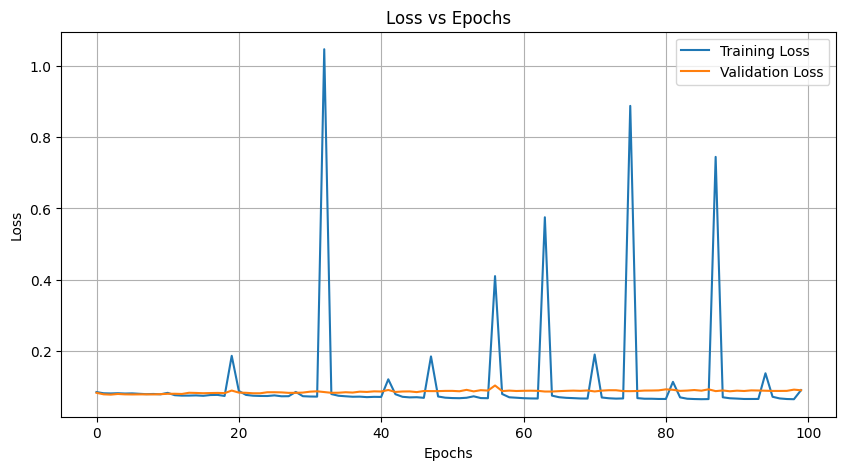

In [225]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_avg, label='Training Loss')
plt.plot(validation_loss_avg, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

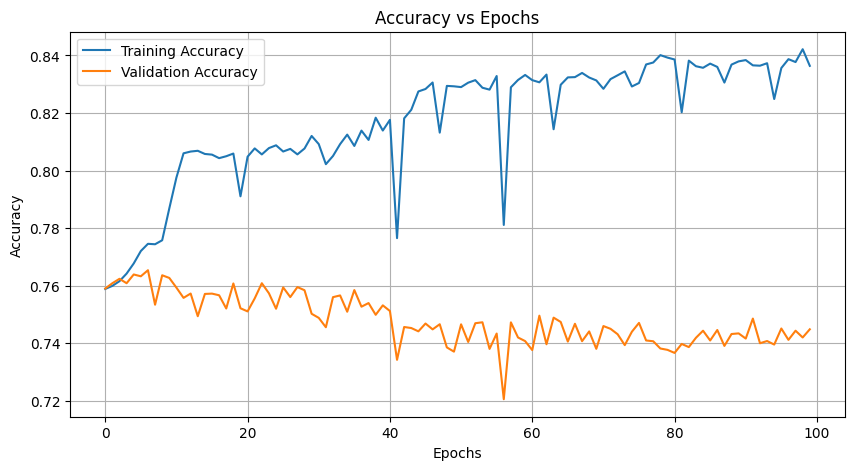

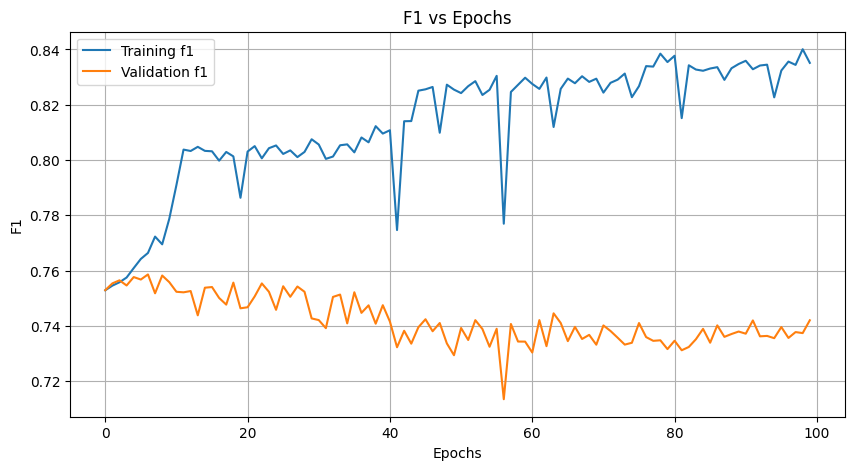

Final Train Accuracy: 0.8364, Final Train F1: 0.8351
Final Validation Accuracy: 0.7448, Final Validation F1: 0.7420


In [226]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_f1_list, label='Training f1')
plt.plot(val_f1_list, label='Validation f1')
plt.title('F1 vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
plt.grid()
plt.show()

print(f"Final Train Accuracy: {train_acc_list[-1]:.4f}, Final Train F1: {train_f1_list[-1]:.4f}")
print(f'Final Validation Accuracy: {val_acc_list[-1]:.4f}, Final Validation F1: {val_f1_list[-1]:.4f}')

### 2d) Encontrar usuarios similares (1 punto)
Para el modelo del punto 2c) implementar una función que reciba un ID de usuario y sugiera **n** cantidad de usuarios que tuvieron un comportamiento de compras similar. También se debe mostrar el grado o porcentaje de similitud de cada usuario que retorne la función.